<a href="https://colab.research.google.com/github/Sindhee/IIRS_ISRO_Internship_Project/blob/main/amijetomar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Path to the directory
directory = '/content/drive/MyDrive/'

# Iterate through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith(('.tiff', '.tif')):
        file_path = os.path.join(directory, filename)
        os.remove(file_path)
        print(f"Deleted: {filename}")


Deleted: img_82 (4).tiff
Deleted: img_410.tiff
Deleted: img_177 (2).tiff
Deleted: img_510.tiff
Deleted: img_572.tiff
Deleted: img_105 (4).tiff
Deleted: img_33 (4).tiff
Deleted: img_234.tiff
Deleted: img_103 (4).tiff
Deleted: img_45 (4).tiff
Deleted: img_575.tiff
Deleted: img_589.tiff
Deleted: img_309.tiff
Deleted: img_173 (2).tiff
Deleted: img_336.tiff
Deleted: img_602.tiff
Deleted: img_374.tiff
Deleted: img_289.tiff
Deleted: img_507.tiff
Deleted: img_350.tiff
Deleted: img_210.tiff
Deleted: img_590.tiff
Deleted: img_421.tiff
Deleted: img_11 (4).tiff
Deleted: img_232.tiff
Deleted: img_22 (4).tiff
Deleted: img_159 (4).tiff
Deleted: img_58 (4).tiff
Deleted: img_496.tiff
Deleted: img_188 (2).tiff
Deleted: img_147 (4).tiff
Deleted: img_427.tiff
Deleted: img_178 (2).tiff
Deleted: img_317.tiff
Deleted: img_262.tiff
Deleted: img_486.tiff
Deleted: img_303.tiff
Deleted: img_158 (4).tiff
Deleted: img_168 (2).tiff
Deleted: img_525.tiff
Deleted: img_40 (4).tiff
Deleted: img_598.tiff
Deleted: img_52

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub

import zipfile

In [ ]:

# Load the 4x super-resolution model
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")  # ESRGAN model for super-resolution

# Specify the input folders
satellite_input_folder = '/content/drive/MyDrive/full_data/data_files/processed_satelliteimg_tile/_2Delhi_NCR_Satellite_data_satellite_tiles'  # Replace with your satellite image folder path
mask_input_folder = '/content/drive/MyDrive/full_data/data_files/processed_masks_tile/_2Delhi_NCR_Satellite_data_mask_tiles'

# Output folders for TIFF and JPEG formats
output_folder = '/content/super3_resolution'
satellite_output_tiff = os.path.join(output_folder, 'satellite_tiff')
satellite_output_jpg = os.path.join(output_folder, 'satellite_jpg')
mask_output_tiff = os.path.join(output_folder, 'mask_tiff')
mask_output_jpg = os.path.join(output_folder, 'mask_jpg')

# Create output directories if they don't exist
os.makedirs(satellite_output_tiff, exist_ok=True)
os.makedirs(satellite_output_jpg, exist_ok=True)
os.makedirs(mask_output_tiff, exist_ok=True)
os.makedirs(mask_output_jpg, exist_ok=True)


In [ ]:
# Super-resolution function for satellite images and masks
def super_resolve_and_save(input_path, output_path_tiff, output_path_jpg, is_mask=False):
    # Load the image
    img = Image.open(input_path)

    if is_mask:
        # For binary masks, use nearest-neighbor interpolation to preserve binary values (0 and 1)
        img = img.convert('L')  # Convert to grayscale (single channel)
        img_resized = img.resize((img.width * 4, img.height * 4), Image.NEAREST)  # 4x upscale for masks
    else:
        # For satellite images, apply ESRGAN super-resolution
        img = img.convert('RGB')  # Ensure RGB for satellite images

        # Normalize and apply the super-resolution model
        img_array = np.array(img) / 255.0  # Normalize the image
        img_array = np.expand_dims(img_array, axis=0).astype(np.float32)  # Ensure dtype is float32 for model compatibility

        # Use the ESRGAN model to enhance resolution
        super_resolved = model(img_array)
        super_resolved = np.clip(super_resolved[0].numpy(), 0.0, 1.0)  # Ensure pixel values are between 0 and 1

        # Convert the enhanced image back to a format suitable for saving
        img_resized = Image.fromarray((super_resolved * 255).astype(np.uint8))  # Convert back to [0, 255] uint8

    # Save the enhanced image in TIFF and JPEG formats
    img_resized.save(output_path_tiff, format='TIFF')
    img_resized.save(output_path_jpg, format='JPEG')

    print(f"Saved enhanced image to {output_path_tiff} and {output_path_jpg}")


In [ ]:
import os
import pickle

# Parameters for batch processing and checkpoint management
batch_size = 1000
checkpoint_file = "processing_checkpoint.pkl"

# Load checkpoint for tracking progress
def load_checkpoint():
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, "rb") as f:
            checkpoint = pickle.load(f)
            return checkpoint.get("last_index", 0)
    return 0

# Save checkpoint to track processed index
def save_checkpoint(last_index):
    with open(checkpoint_file, "wb") as f:
        pickle.dump({"last_index": last_index}, f)

# Process satellite images and masks
def process_images(batch_size, last_index):
    # Get the list of common file names between satellite and mask folders
    satellite_files = set(f for f in os.listdir(satellite_input_folder) if f.endswith((".tif", ".jpg", ".png")))
    mask_files = set(f for f in os.listdir(mask_input_folder) if f.endswith((".tif", ".jpg", ".png")))
    common_files = sorted(list(satellite_files.intersection(mask_files)))[last_index:last_index + batch_size]

    # Process each pair of matching satellite image and mask
    for filename in common_files:
        try:
            # Satellite image paths
            input_path_satellite = os.path.join(satellite_input_folder, filename)
            output_path_satellite_tiff = os.path.join(satellite_output_tiff, f"{filename}.tiff")
            output_path_satellite_jpg = os.path.join(satellite_output_jpg, f"{filename}.jpg")

            # Mask paths
            input_path_mask = os.path.join(mask_input_folder, filename)
            output_path_mask_tiff = os.path.join(mask_output_tiff, f"{filename}.tiff")
            output_path_mask_jpg = os.path.join(mask_output_jpg, f"{filename}.jpg")

            # Process satellite image and mask
            print(f"Processing satellite image {filename}...")
            super_resolve_and_save(input_path_satellite, output_path_satellite_tiff, output_path_satellite_jpg, is_mask=False)

            print(f"Processing mask {filename}...")
            super_resolve_and_save(input_path_mask, output_path_mask_tiff, output_path_mask_jpg, is_mask=True)

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue

    print("Super-resolution processing completed for current batch.")

# Main loop
if __name__ == "__main__":
    last_index = load_checkpoint()  # Load the last processed index
    process_images(batch_size, last_index)  # Process the batch

    # Update the checkpoint to prevent reprocessing
    save_checkpoint(last_index + batch_size)


Processing satellite image tile_11520_5248.tif...
Saved enhanced image to /content/super3_resolution/satellite_tiff/tile_11520_5248.tif.tiff and /content/super3_resolution/satellite_jpg/tile_11520_5248.tif.jpg
Processing mask tile_11520_5248.tif...
Saved enhanced image to /content/super3_resolution/mask_tiff/tile_11520_5248.tif.tiff and /content/super3_resolution/mask_jpg/tile_11520_5248.tif.jpg
Processing satellite image tile_11520_5376.tif...
Saved enhanced image to /content/super3_resolution/satellite_tiff/tile_11520_5376.tif.tiff and /content/super3_resolution/satellite_jpg/tile_11520_5376.tif.jpg
Processing mask tile_11520_5376.tif...
Saved enhanced image to /content/super3_resolution/mask_tiff/tile_11520_5376.tif.tiff and /content/super3_resolution/mask_jpg/tile_11520_5376.tif.jpg
Processing satellite image tile_11520_5504.tif...
Saved enhanced image to /content/super3_resolution/satellite_tiff/tile_11520_5504.tif.tiff and /content/super3_resolution/satellite_jpg/tile_11520_5504.

In [ ]:
import zipfile


In [ ]:
# Zip the output folder for download
zip_file_path = '/content/super3_resolution.zip'
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(output_folder):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_folder))

print(f"Zipping completed. The file is saved as {zip_file_path}.")

Zipping completed. The file is saved as /content/super3_resolution.zip.


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split

# Specify the input folders
satellite_input_folder = '/content/drive/MyDrive/full_data/data_files/processed_satelliteimg_tile/_2Delhi_NCR_Satellite_data_satellite_tiles'
mask_input_folder = '/content/drive/MyDrive/full_data/data_files/processed_masks_tile/_2Delhi_NCR_Satellite_data_mask_tiles'

# Output folders for TIFF and JPEG formats
output_folder = '/content/super3_resolution'
satellite_output_tiff = os.path.join(output_folder, 'satellite_tiff')
mask_output_tiff = os.path.join(output_folder, 'mask_tiff')

# Define the target folders for the splits
train_sat_folder = '/content/train/satellite_tiff'
val_sat_folder = '/content/val/satellite_tiff'
test_sat_folder = '/content/test/satellite_tiff'
train_mask_folder = '/content/train/masks_tiff'
val_mask_folder = '/content/val/masks_tiff'
test_mask_folder = '/content/test/masks_tiff'

# Ensure the target directories exist
os.makedirs(train_sat_folder, exist_ok=True)
os.makedirs(val_sat_folder, exist_ok=True)
os.makedirs(test_sat_folder, exist_ok=True)
os.makedirs(train_mask_folder, exist_ok=True)
os.makedirs(val_mask_folder, exist_ok=True)
os.makedirs(test_mask_folder, exist_ok=True)

# Get the list of files in the source directories
satellite_files = sorted(os.listdir(satellite_output_tiff))
mask_files = sorted(os.listdir(mask_output_tiff))

# Splitting data into train, validation, and test sets
train_sat, test_sat, train_mask, test_mask = train_test_split(satellite_files, mask_files, test_size=0.2, random_state=42)
train_sat, val_sat, train_mask, val_mask = train_test_split(train_sat, train_mask, test_size=0.25, random_state=42)  # 20% test, 20% val, 60% train

# Helper function to copy files to split folders
def save_split_data(file_list, source_folder, target_folder):
    for filename in file_list:
        src_path = os.path.join(source_folder, filename)
        dest_path = os.path.join(target_folder, filename)
        # Open and save the image to the target folder
        Image.open(src_path).save(dest_path)

# Saving train, val, test splits
save_split_data(train_sat, satellite_output_tiff, train_sat_folder)
save_split_data(val_sat, satellite_output_tiff, val_sat_folder)
save_split_data(test_sat, satellite_output_tiff, test_sat_folder)
save_split_data(train_mask, mask_output_tiff, train_mask_folder)
save_split_data(val_mask, mask_output_tiff, val_mask_folder)
save_split_data(test_mask, mask_output_tiff, test_mask_folder)

print("Data splitting and saving completed.")


Data splitting and saving completed.


In [ ]:
# Check for missing files
satellite_files_set = set(satellite_files)
mask_files_set = set(mask_files)

# Find unmatched files
missing_in_satellite = mask_files_set - satellite_files_set
missing_in_mask = satellite_files_set - mask_files_set

if missing_in_satellite:
    print("Files present in masks but missing in satellite images:", missing_in_satellite)
if missing_in_mask:
    print("Files present in satellite images but missing in masks:", missing_in_mask)


Files present in masks but missing in satellite images: {'tile_128_4864.tif.tiff', 'tile_896_8064.tif.tiff', 'tile_512_6400.tif.tiff', 'tile_896_4736.tif.tiff', 'tile_0_1024.tif.tiff', 'tile_896_2816.tif.tiff', 'tile_640_2944.tif.tiff', 'tile_256_1024.tif.tiff', 'tile_512_3200.tif.tiff', 'tile_256_5632.tif.tiff', 'tile_0_9344.tif.tiff', 'tile_896_3328.tif.tiff', 'tile_512_4736.tif.tiff', 'tile_640_2688.tif.tiff', 'tile_512_2048.tif.tiff', 'tile_512_2560.tif.tiff', 'tile_1024_6528.tif.tiff', 'tile_128_5888.tif.tiff', 'tile_384_1024.tif.tiff', 'tile_768_7936.tif.tiff', 'tile_640_640.tif.tiff', 'tile_256_5248.tif.tiff', 'tile_768_1920.tif.tiff', 'tile_896_6400.tif.tiff', 'tile_512_3456.tif.tiff', 'tile_512_6528.tif.tiff', 'tile_896_2560.tif.tiff', 'tile_256_2944.tif.tiff', 'tile_896_4224.tif.tiff', 'tile_256_3456.tif.tiff', 'tile_896_4480.tif.tiff', 'tile_128_7296.tif.tiff', 'tile_768_4864.tif.tiff', 'tile_256_3584.tif.tiff', 'tile_768_2432.tif.tiff', 'tile_512_5120.tif.tiff', 'tile_384_2

In [ ]:
# Get filenames without extensions and with extensions normalized
satellite_files = {f.replace('.tiff', ''): f for f in sorted(os.listdir(satellite_output_tiff))}
mask_files = {f.replace('.tiff', ''): f for f in sorted(os.listdir(mask_output_tiff))}

# Find common files in both folders
common_files = satellite_files.keys() & mask_files.keys()
satellite_files = [satellite_files[f] for f in common_files]
mask_files = [mask_files[f] for f in common_files]


In [ ]:
from sklearn.model_selection import train_test_split
train_sat, test_sat, train_mask, test_mask = train_test_split(
    satellite_files, mask_files, test_size=0.2, random_state=42)
train_sat, val_sat, train_mask, val_mask = train_test_split(
    train_sat, train_mask, test_size=0.25, random_state=42)  # 20% test, 20% val, 60% train


In [ ]:
import os

output_folder = '/content/super3_resolution'
satellite_output_tiff = os.path.join(output_folder, 'satellite_tiff')

mask_output_tiff = os.path.join(output_folder, 'mask_tiff')


# Get and sort filenames
satellite_files = sorted(os.listdir(satellite_output_tiff))
mask_files = sorted(os.listdir(mask_output_tiff))

# Convert lists to sets for comparison
satellite_set = set(satellite_files)
mask_set = set(mask_files)

# Identify unmatched files
unmatched_satellite_files = satellite_set - mask_set
unmatched_mask_files = mask_set - satellite_set

# Filter out unmatched files
satellite_files_matched = [f for f in satellite_files if f not in unmatched_satellite_files]
mask_files_matched = [f for f in mask_files if f not in unmatched_mask_files]

# Now split using only matched files
from sklearn.model_selection import train_test_split

train_sat, test_sat, train_mask, test_mask = train_test_split(satellite_files_matched, mask_files_matched, test_size=0.2, random_state=42)
train_sat, val_sat, train_mask, val_mask = train_test_split(train_sat, train_mask, test_size=0.25, random_state=42)  # 20% test, 20% val, 60% train

print("Training set size:", len(train_sat))
print("Validation set size:", len(val_sat))
print("Test set size:", len(test_sat))


Training set size: 600
Validation set size: 200
Test set size: 200


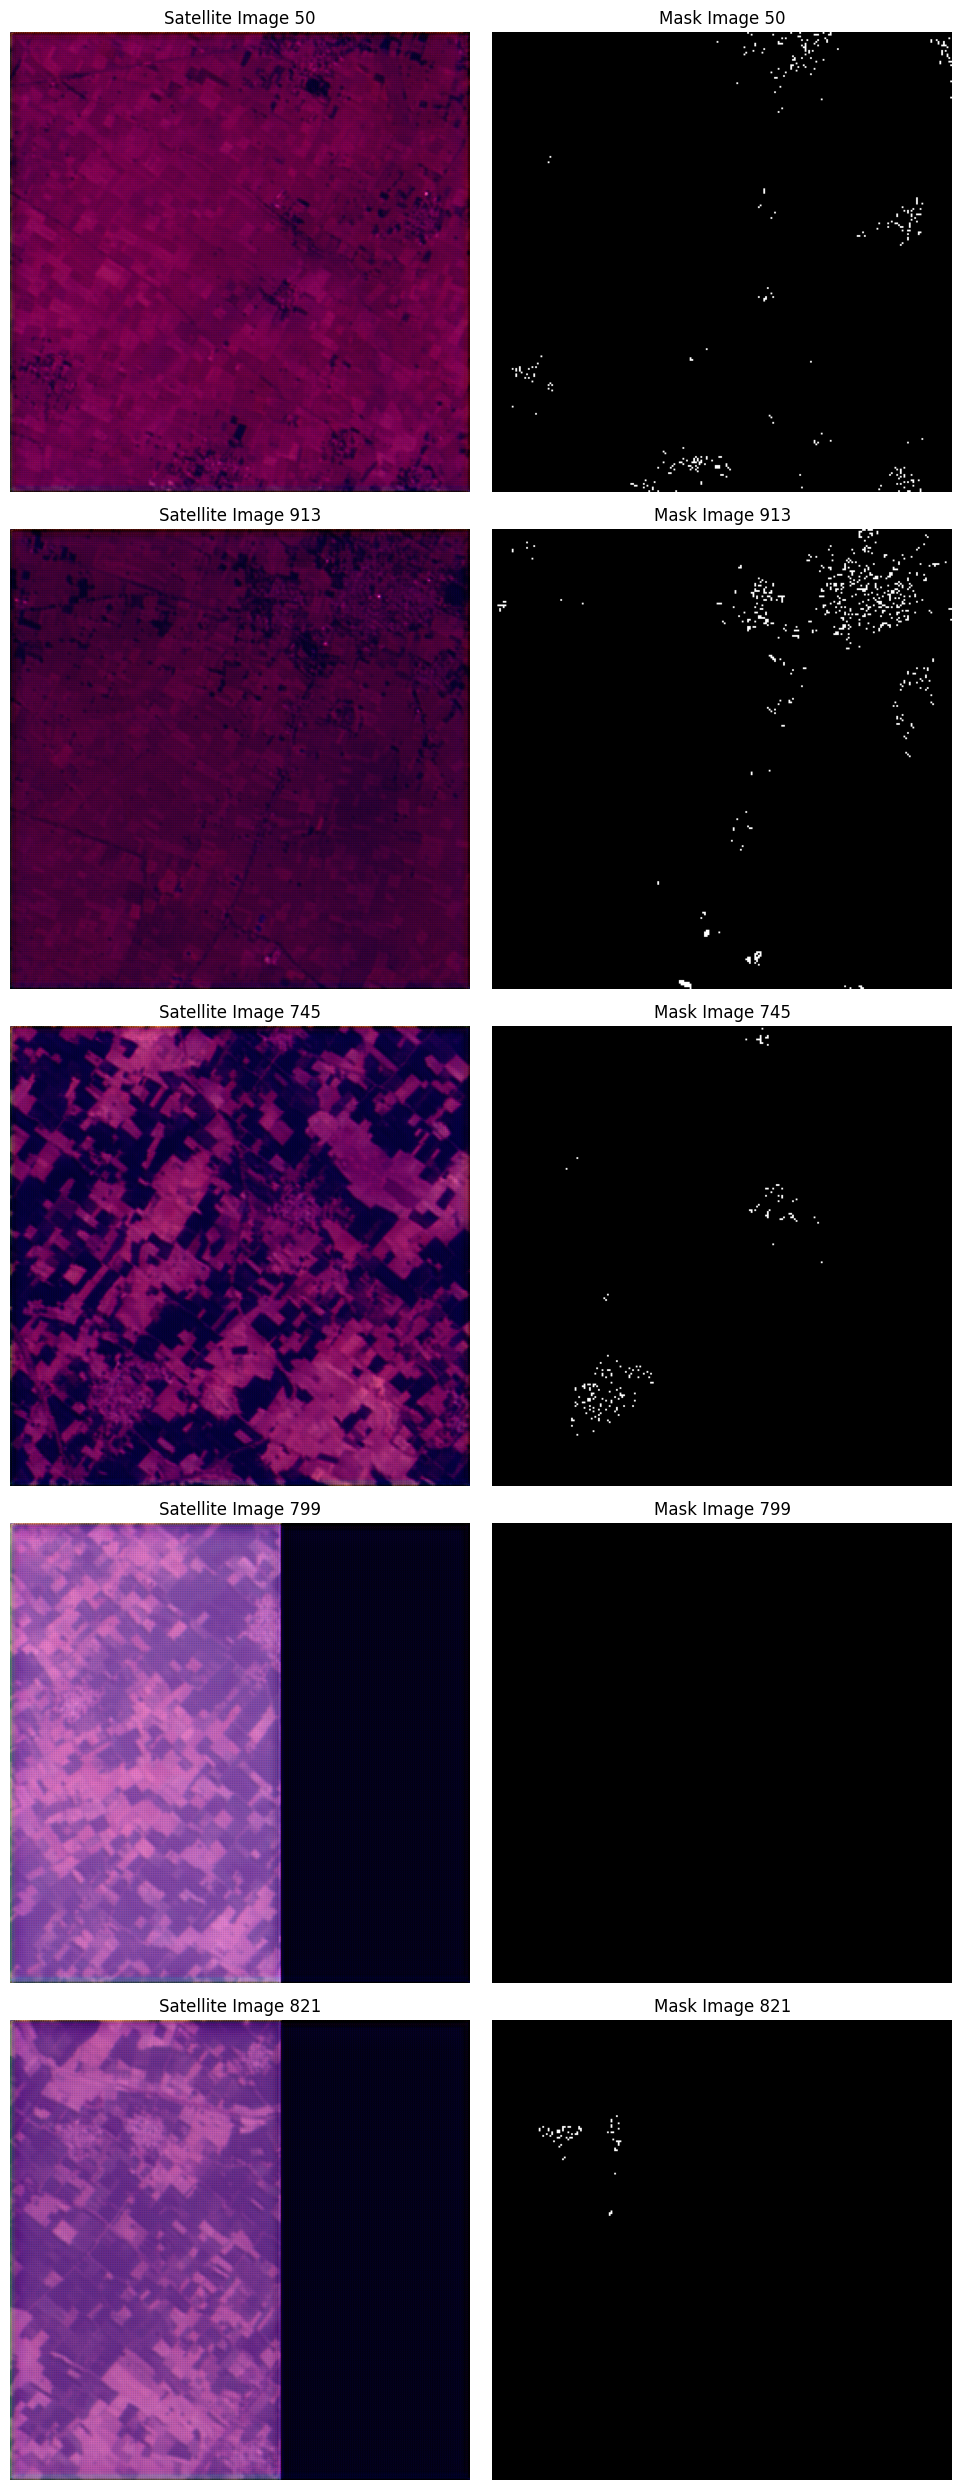

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Paths to your directories
output_folder = '/content/super3_resolution'
satellite_output_tiff = os.path.join(output_folder, 'satellite_tiff')
mask_output_tiff = os.path.join(output_folder, 'mask_tiff')

def visualize_satellite_and_mask(satellite_path, mask_path, n_samples=5):
    """
    Visualizes n_samples of satellite images and their corresponding masks.
    """
    # Select random sample indices
    sample_indices = np.random.choice(range(len(satellite_path)), n_samples, replace=False)

    plt.figure(figsize=(10, 5 * n_samples))

    for i, idx in enumerate(sample_indices):
        # Construct the file paths for satellite and mask images
        satellite_file = os.path.join(satellite_output_tiff, satellite_path[idx])
        mask_file = os.path.join(mask_output_tiff, mask_path[idx])

        # Check if the files exist
        if not os.path.exists(satellite_file):
            print(f"Satellite file {satellite_file} not found.")
            continue  # Skip this sample if the file doesn't exist
        if not os.path.exists(mask_file):
            print(f"Mask file {mask_file} not found.")
            continue  # Skip this sample if the file doesn't exist

        # Load satellite image and mask
        satellite_img = Image.open(satellite_file)
        mask_img = Image.open(mask_file)

        # Plot satellite image
        plt.subplot(n_samples, 2, 2 * i + 1)
        plt.imshow(satellite_img)
        plt.title(f'Satellite Image {idx + 1}')
        plt.axis('off')

        # Plot mask image
        plt.subplot(n_samples, 2, 2 * i + 2)
        plt.imshow(mask_img, cmap='gray')
        plt.title(f'Mask Image {idx + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 5 random samples
visualize_satellite_and_mask(satellite_files_matched, mask_files_matched, n_samples=5)



Mask Pixel Values (as an array):
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Unique Pixel Values in Mask: [0 1]


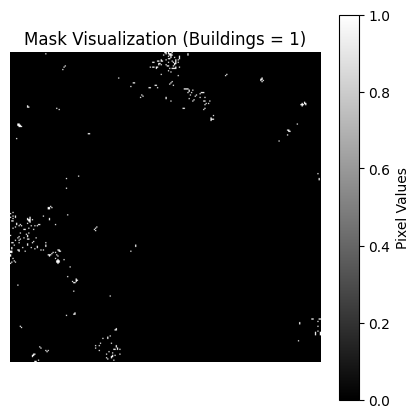

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Function to display mask and print pixel values
def inspect_mask(mask_file_path, show_plot=True):
    """
    Loads and inspects the mask file, displaying and printing pixel values.
    """
    # Load mask image and convert it to grayscale array
    mask_img = Image.open(mask_file_path).convert('L')
    mask_array = np.array(mask_img)

    # Print the pixel values to inspect
    print("Mask Pixel Values (as an array):\n", mask_array)
    print("Unique Pixel Values in Mask:", np.unique(mask_array))

    # Optional: Plot the mask with highlighted building areas (where value = 1)
    if show_plot:
        plt.figure(figsize=(5, 5))
        plt.imshow(mask_array, cmap='gray', vmin=0, vmax=1)  # Assuming binary 0/1 mask
        plt.colorbar(label='Pixel Values')
        plt.title('Mask Visualization (Buildings = 1)')
        plt.axis('off')
        plt.show()

# Example usage with one mask file
mask_file_path = os.path.join(mask_output_tiff, mask_files_matched[0])
inspect_mask(mask_file_path)


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to visualize RGB mask
def visualize_rgb_mask(mask_file_path):
    """
    Loads and visualizes the original RGB mask file.
    """
    # Load mask image in RGB
    mask_img = Image.open(mask_file_path)

    # Plot the RGB mask
    plt.figure(figsize=(6, 6))
    plt.imshow(mask_img)
    plt.title('Original RGB Mask Visualization')
    plt.axis('off')
    plt.show()

# Example usage with your mask file path
mask_file_path = '/content/super3_resolution/mask_tiff/tile_11520_5248.tif.tiff'  # Replace with your actual mask path if different
visualize_rgb_mask(mask_file_path)


Unique RGB colors in the mask:
[[0 0 0]
 [1 1 1]]


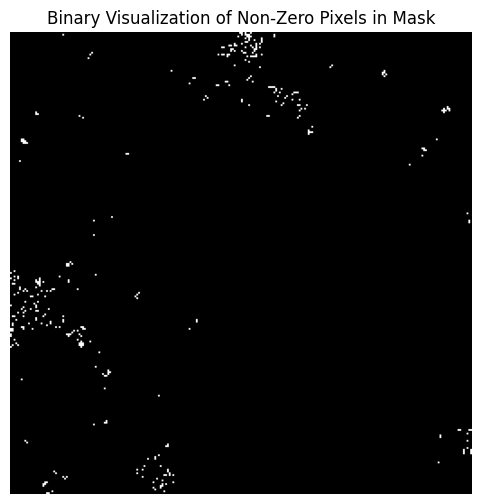

In [ ]:
import numpy as np
from PIL import Image

def analyze_rgb_mask(mask_file_path):
    # Load the mask in RGB mode
    mask_img = Image.open(mask_file_path).convert("RGB")
    mask_array = np.array(mask_img)

    # Find unique RGB values in the mask
    unique_colors = np.unique(mask_array.reshape(-1, 3), axis=0)

    # Display the unique colors
    print("Unique RGB colors in the mask:")
    print(unique_colors)

    # If there are any non-zero RGB colors, visualize as binary
    if len(unique_colors) > 1:
        binary_mask = (mask_array > 0).any(axis=2).astype(np.uint8) * 255
        plt.figure(figsize=(6, 6))
        plt.imshow(binary_mask, cmap='gray')
        plt.title("Binary Visualization of Non-Zero Pixels in Mask")
        plt.axis('off')
        plt.show()
    else:
        print("The mask appears to be mostly a single color.")

# Run the analysis function with your mask file path
  # Replace if different
analyze_rgb_mask(mask_file_path)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize_grayscale_mask(mask_file_path):
    # Load the mask in RGB mode
    mask_img = Image.open(mask_file_path).convert("RGB")
    mask_array = np.array(mask_img)

    # Convert the RGB mask to grayscale by averaging the color channels
    grayscale_mask = mask_array.mean(axis=2)

    # Apply a contrast stretch for better visibility
    stretched_mask = (grayscale_mask - grayscale_mask.min()) / (grayscale_mask.max() - grayscale_mask.min())

    # Visualize the stretched grayscale mask
    plt.figure(figsize=(8, 8))
    plt.imshow(stretched_mask, cmap='gray')
    plt.colorbar(label='Pixel Values')
    plt.title("Enhanced Grayscale Visualization of Mask")
    plt.axis('off')
    plt.show()

# Run the function with your mask file path
 # Replace if different
visualize_grayscale_mask(mask_file_path)


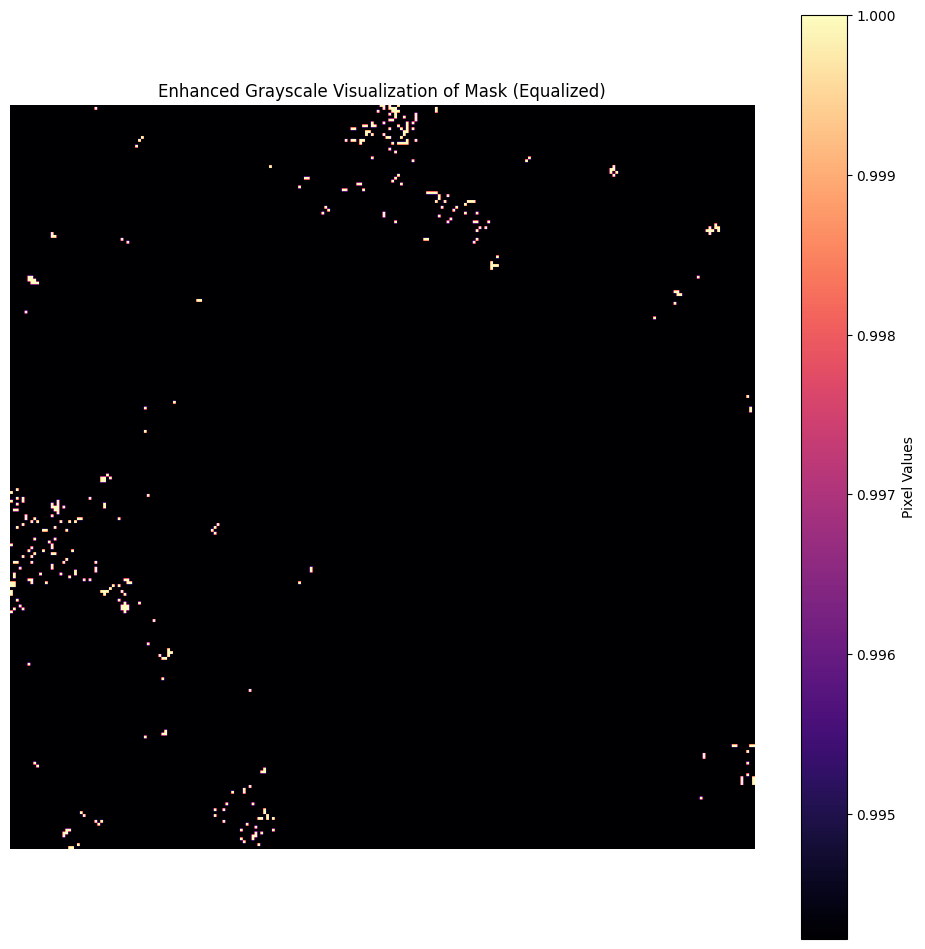

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import exposure

def enhanced_visualize_grayscale_mask(mask_file_path):
    # Load the mask in RGB mode
    mask_img = Image.open(mask_file_path).convert("RGB")
    mask_array = np.array(mask_img)

    # Convert the RGB mask to grayscale by averaging the color channels
    grayscale_mask = mask_array.mean(axis=2)

    # Apply histogram equalization for better contrast
    equalized_mask = exposure.equalize_hist(grayscale_mask)

    # Plot the enhanced grayscale mask
    plt.figure(figsize=(12, 12))  # Increase the figure size
    plt.imshow(equalized_mask, cmap='magma')  # Use 'magma' for better visibility
    plt.colorbar(label='Pixel Values')
    plt.title("Enhanced Grayscale Visualization of Mask (Equalized)")
    plt.axis('off')
    plt.show()

# Run the function with your mask file path

enhanced_visualize_grayscale_mask(mask_file_path)


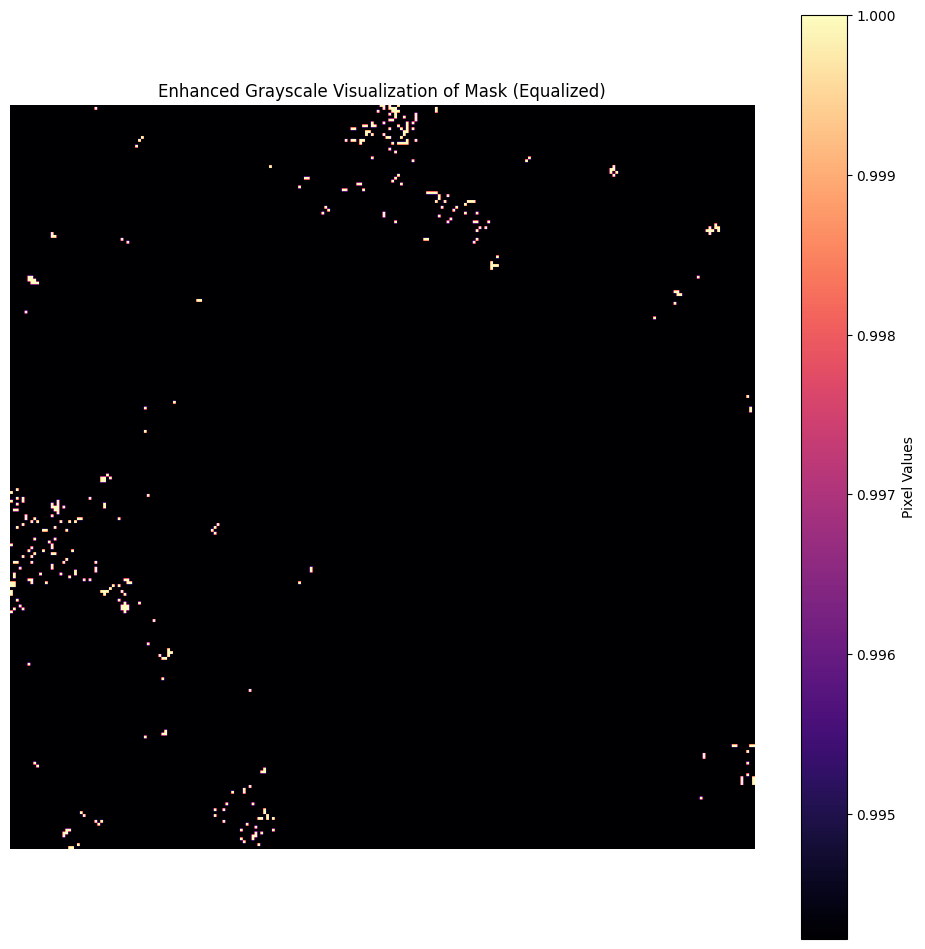

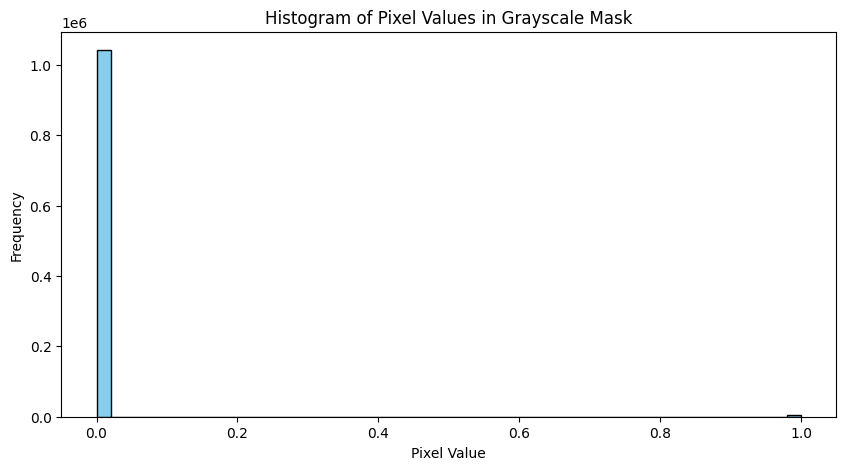

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import exposure

def enhanced_visualize_grayscale_mask(mask_file_path):
    # Load the mask in RGB mode
    mask_img = Image.open(mask_file_path).convert("RGB")
    mask_array = np.array(mask_img)

    # Convert the RGB mask to grayscale by averaging the color channels
    grayscale_mask = mask_array.mean(axis=2)

    # Apply histogram equalization for better contrast
    equalized_mask = exposure.equalize_hist(grayscale_mask)

    # Plot the enhanced grayscale mask
    plt.figure(figsize=(12, 12))
    plt.imshow(equalized_mask, cmap='magma')
    plt.colorbar(label='Pixel Values')
    plt.title("Enhanced Grayscale Visualization of Mask (Equalized)")
    plt.axis('off')
    plt.show()

    # Return the grayscale mask
    return grayscale_mask

# Run the function and store the grayscale mask

grayscale_mask = enhanced_visualize_grayscale_mask(mask_file_path)

# Plot histogram of pixel values
pixel_values = grayscale_mask.flatten()

plt.figure(figsize=(10, 5))
plt.hist(pixel_values, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Pixel Values in Grayscale Mask")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


In [ ]:
unique_values, counts = np.unique(grayscale_mask, return_counts=True)
print("Unique Pixel Values:", unique_values)
print("Counts:", counts)


Unique Pixel Values: [0. 1.]
Counts: [1042512    6064]


In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 83.0 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np

# Path to the original mask file
mask_path = '/content/drive/MyDrive/full_data/data_files/processed_masks_tile/_2Delhi_NCR_Satellite_data_mask_tiles/tile_0_0.tif'

# Open the mask file using rasterio
with rasterio.open(mask_path) as src:
    # Read the mask data as a numpy array
    mask_data = src.read(1)  # Assuming the mask is the first band

# Check if all pixel values are either 0 or 1
unique_values = np.unique(mask_data)

if set(unique_values) == {0, 1}:
    print("The mask has a strict binary structure (only 0 and 1 values).")
else:
    print(f"The mask contains other values: {unique_values}")


The mask has a strict binary structure (only 0 and 1 values).


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Read the mask with correct settings
with rasterio.open('/content/drive/MyDrive/full_data/data_files/processed_masks_tile/_2Delhi_NCR_Satellite_data_mask_tiles/tile_0_0.tif') as src:
    mask = src.read(1)

# Check the unique values
unique_values = np.unique(mask)
print("Unique Values in Mask:", unique_values)

# Visualize the mask correctly
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
plt.title("Binary Mask Visualization")
plt.axis('off')
plt.colorbar(label='Pixel Value (0 = Background, 1 = Building)')
plt.show()


Unique Values in Mask: [0 1]


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Read the mask with correct settings
with rasterio.open('/content/super3_resolution/mask_tiff/tile_11520_5248.tif.tiff') as src:
    mask = src.read(1)

# Check the unique values
unique_values = np.unique(mask)
print("Unique Values in Mask:", unique_values)

# Visualize the mask correctly
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
plt.title("Binary Mask Visualization")
plt.axis('off')
plt.colorbar(label='Pixel Value (0 = Background, 1 = Building)')
plt.show()


Unique Values in Mask: [0 1]


In [ ]:
import os
import shutil

# Function to calculate folder size in GB
def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)
    return total_size / (1024 * 1024 * 1024)  # Size in GB

# Check the size of the 'super3_resolution' folder
source_folder = '/content/super3_resolution'
folder_size_gb = get_folder_size(source_folder)

print(f"Size of the folder 'super3_resolution': {folder_size_gb:.2f} GB")

# Check available space in Google Drive using the Google Colab filesystem
drive_path = '/content/drive/MyDrive'
total_drive_size = shutil.disk_usage(drive_path).total / (1024 * 1024 * 1024)  # Total space in GB
free_drive_size = shutil.disk_usage(drive_path).free / (1024 * 1024 * 1024)   # Free space in GB

print(f"Total space in Google Drive: {total_drive_size:.2f} GB")
print(f"Free space in Google Drive: {free_drive_size:.2f} GB")

# Check if there is enough space in Google Drive
if folder_size_gb <= free_drive_size:
    print("There is enough space to save the folder.")
else:
    print("Not enough space available in Google Drive.")


Size of the folder 'super3_resolution': 4.11 GB
Total space in Google Drive: 15.00 GB
Free space in Google Drive: 7.49 GB
There is enough space to save the folder.


In [ ]:
import os

# Check if the destination folder really exists
destination_folder = '/content/drive/MyDrive/super4x3_resolution'
print(f"Does the destination folder exist? {os.path.exists(destination_folder)}")


Does the destination folder exist? False


In [ ]:
import shutil

# Delete the destination folder if it still exists
if os.path.exists(destination_folder):
    shutil.rmtree(destination_folder)
    print(f"Deleted folder: {destination_folder}")


Deleted folder: /content/drive/MyDrive/super4x3_resolution


In [ ]:
import shutil
import os

# Specify the source and destination directories
source_folder = '/content/super3_resolution'
destination_folder = '/content/drive/MyDrive/super4x3_resolution'


print(f"Created folder: {destination_folder}")

# Copy the super3_resolution folder to Google Drive
shutil.copytree(source_folder, destination_folder)

print(f"Folder 'super3_resolution' has been copied to Google Drive: {destination_folder}")


Created folder: /content/drive/MyDrive/super4x3_resolution
Folder 'super3_resolution' has been copied to Google Drive: /content/drive/MyDrive/super4x3_resolution


In [ ]:
# rough

In [ ]:
import os
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, jaccard_score
import tensorflow as tf
from tensorflow.keras.models import load_model

def load_test_dataset_with_masks(test_image_folder, test_mask_folder):
    images = []
    masks = []

    image_files = sorted(os.listdir(test_image_folder))
    mask_files = sorted(os.listdir(test_mask_folder))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(test_image_folder, img_file)
        mask_path = os.path.join(test_mask_folder, mask_file)

        # Load the image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to read image {img_path}")
            continue
        img = cv2.resize(img, (256, 256))
        images.append(img)

        # Load the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Warning: Unable to read mask {mask_path}")
            continue
        mask = cv2.resize(mask, (256, 256))
        masks.append(mask)

    return np.array(images), np.array(masks)

# Specify paths for your test images and masks
test_image_folder = '/content/drive/MyDrive/full_data/data_files/processed_satelliteimg_tile/_1Delhi_NCR_Satellite_data_satellite_tiles'
test_mask_folder = '/content/drive/MyDrive/full_data/data_files/processed_masks_tile/_1Delhi_NCR_Satellite_data_mask_tiles'

# Load the test dataset with images and ground truth masks
test_images, test_masks = load_test_dataset_with_masks(test_image_folder, test_mask_folder)

# Preprocess the test data
test_images = test_images.astype('float32') / 255.0
test_masks = (test_masks > 0).astype('float32')  # Binary mask conversion if needed

# Load the trained model
model_path = '/content/drive/MyDrive/full_data/saved_trained_model/my_resnet50_model_final'
model = load_model(model_path)

# Predict the masks for the test images
predicted_masks = model.predict(test_images)
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)  # Thresholding for binary segmentation

# Flatten masks for sklearn metrics
true_masks_flat = test_masks.flatten()
predicted_masks_flat = predicted_masks.flatten()

# Calculate Accuracy
accuracy = accuracy_score(true_masks_flat, predicted_masks_flat)
print(f"Accuracy: {accuracy}")

# Calculate IoU (Jaccard Index)
iou_score = jaccard_score(true_masks_flat, predicted_masks_flat, average='binary')
print(f"IoU Score: {iou_score}")

# Calculate Dice Coefficient
dice_coef = 2 * np.sum(predicted_masks * test_masks) / (np.sum(predicted_masks) + np.sum(test_masks))
print(f"Dice Coefficient: {dice_coef}")

In [ ]:
#this is my model training code

import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, ZeroPadding2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import glorot_uniform


import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add,
    ZeroPadding2D, MaxPooling2D, AveragePooling2D, Dropout,
    UpSampling2D
)
from tensorflow.keras.initializers import glorot_uniform

# Define the ResNet50 architecture
def identity_block(X, f, filters, stage, block, l2_reg=0.01):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2, l2_reg=0.01):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a', padding='valid',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides=(1, 1), name=conv_name_base + '2b', padding='same',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides=(1, 1), name=conv_name_base + '2c', padding='valid',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), name=conv_name_base + '1', padding='valid',
                        kernel_initializer=glorot_uniform(seed=0),
                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(256, 256, 3), classes=1):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')

    # Average Pooling
    X = AveragePooling2D(pool_size=(2, 2))(X)

    # Add Dropout layer
    X = Dropout(0.5)(X)

    # Instead of Flatten, directly add the output layer
    X = Conv2D(classes, (1, 1), activation='sigmoid', name='output')(X)

    # Upsample to the desired output size (adjust this as needed)
    X = UpSampling2D(size=(32, 32), interpolation='bilinear')(X)

    # Update the model creation with a name
    model = tf.keras.models.Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

# Compile the model
model = ResNet50(input_shape=(256, 256, 3), classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Use your data loading function and train the model

import os
import numpy as np
import cv2

def load_full_dataset(train_image_folder, train_mask_folder):
    images = []
    masks = []

    # List all image files in the image folder
    image_files = sorted(os.listdir(train_image_folder))
    mask_files = sorted(os.listdir(train_mask_folder))

    for img_file, mask_file in zip(image_files, mask_files):
        # Construct full file path
        img_path = os.path.join(train_image_folder, img_file)
        mask_path = os.path.join(train_mask_folder, mask_file)

        # Load the image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to read image {img_path}")
            continue
        img = cv2.resize(img, (256, 256))  # Resize to match the model input

        # Load the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        if mask is None:
            print(f"Warning: Unable to read mask {mask_path}")
            continue
        mask = cv2.resize(mask, (256, 256))  # Resize to match the model input

        # Append to lists
        images.append(img)
        masks.append(mask.reshape((256, 256, 1)))  # Add channel dimension to masks

    return np.array(images), np.array(masks)

# Specify your folder paths
train_image_folder = '/content/drive/MyDrive/full_data/data_files/processed_satelliteimg_tile/_2Delhi_NCR_Satellite_data_satellite_tiles'
train_mask_folder = '/content/drive/MyDrive/full_data/data_files/processed_masks_tile/_2Delhi_NCR_Satellite_data_mask_tiles'

# Load your entire dataset
all_images, all_masks = load_full_dataset(train_image_folder, train_mask_folder)

# Ensure the data is in the right shape
print(f"Loaded images shape: {all_images.shape}")  # Should be (99, 256, 256, 3)
print(f"Loaded masks shape: {all_masks.shape}")    # Should be (99, 256, 256, 1)

# Normalize images if necessary
all_images = all_images.astype('float32') / 255.0
all_masks = all_masks.astype('float32') / 255.0  # Ensure masks are also in the right format

# Check the normalized data shapes
print(f"Normalized images shape: {all_images.shape}")
print(f"Normalized masks shape: {all_masks.shape}")

model = ResNet50(input_shape=(256, 256, 3), classes=1)  # Update the input shape and class count as needed


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)


from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import random

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(
    all_images, all_masks, test_size=0.2, random_state=42
)

# Define the data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

epochs=50

# Fit the model
model.fit(datagen.flow(train_images, train_masks, batch_size=batch_size),
          validation_data=(val_images, val_masks),  # Use the separate validation set
          epochs=epochs,
          callbacks=[early_stopping, reduce_lr, model_checkpoint])


In [ ]:
#training

In [ ]:

#error

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add, UpSampling2D, Dropout, AveragePooling2D, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2

def tversky_loss(alpha=0.5, beta=0.5):
    def loss(y_true, y_pred):
        # Ensure y_true and y_pred have the same shape before flattening
        y_true = tf.cast(y_true, y_pred.dtype)  # Cast to the same data type

        # Remove redundant dimensions if present in y_true
        y_true = tf.squeeze(y_true, axis=-1)  # This will remove any extra dimensions

        # Debugging print to ensure correct shapes
        print("y_true shape:", y_true.shape)  # Debugging line
        print("y_pred shape:", y_pred.shape)  # Debugging line

        smooth = 1e-6
        y_true_pos = tf.keras.backend.flatten(y_true)
        y_pred_pos = tf.keras.backend.flatten(y_pred)
        true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
        false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos))
        false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos)

        return 1 - (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
    return loss


# Atrous Spatial Pyramid Pooling (ASPP) layer
def aspp_block(X, filters, l2_reg=0.01):
    dims = X.shape[1:3]
    pool = AveragePooling2D(pool_size=(dims[0], dims[1]))(X)
    pool = Conv2D(filters, (1, 1), padding="same", kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_reg))(pool)
    pool = UpSampling2D(size=(dims[0], dims[1]), interpolation="bilinear")(pool)

    conv1 = Conv2D(filters, (1, 1), padding="same", kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_reg))(X)
    conv2 = Conv2D(filters, (3, 3), padding="same", dilation_rate=6, kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_reg))(X)
    conv3 = Conv2D(filters, (3, 3), padding="same", dilation_rate=12, kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_reg))(X)
    conv4 = Conv2D(filters, (3, 3), padding="same", dilation_rate=18, kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_reg))(X)

    X = Concatenate()([pool, conv1, conv2, conv3, conv4])
    X = Conv2D(filters, (1, 1), padding="same", kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_reg))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    return X

# Improved Segmentation Model without Skip Connections
def Improved_Segmentation_Model(input_shape=(256, 256, 3), classes=1):
    X_input = Input(input_shape)

    # Initial Convolutional Layers
    X = Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Atrous Convolution Layers (Encoder)
    X = Conv2D(256, (3, 3), padding="same", dilation_rate=2, kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(512, (3, 3), padding="same", dilation_rate=4, kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(1024, (3, 3), padding="same", dilation_rate=8, kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # ASPP Block for multi-scale feature extraction
    X = aspp_block(X, filters=256)

    # Decoder: Upsampling without skip connections
    X = UpSampling2D(size=(2, 2))(X)
    X = Conv2D(256, (3, 3), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = UpSampling2D(size=(2, 2))(X)
    X = Conv2D(128, (3, 3), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = UpSampling2D(size=(2, 2))(X)
    X = Conv2D(64, (3, 3), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Final Convolutional Layer
    # Final output layer for binary segmentation
    X = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=glorot_uniform(seed=0))(X)


    model = Model(inputs=X_input, outputs=X, name='Improved_Segmentation_Model')
    return model

# Compile the model with Tversky Loss and Adam optimizer
model = Improved_Segmentation_Model(input_shape=(256, 256, 3), classes=1)
model.compile(optimizer='adam', loss=tversky_loss(alpha=0.3, beta=0.7), metrics=['accuracy'])


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, Add,
                                     ZeroPadding2D, MaxPooling2D, AveragePooling2D, Dropout, UpSampling2D)
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model

def identity_block(X, f, filters, stage, block, l2_reg=0.01):
    # Identity block for ResNet50
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2, l2_reg=0.01):
    # Convolutional block for ResNet50
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a', padding='valid',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides=(1, 1), name=conv_name_base + '2b', padding='same',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides=(1, 1), name=conv_name_base + '2c', padding='valid',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), name=conv_name_base + '1', padding='valid',
                        kernel_initializer=glorot_uniform(seed=0),
                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(256, 256, 3), classes=1):
    # Define ResNet50 modified for binary segmentation
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stages 2, 3, and 4
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')

    # Average Pooling
    X = AveragePooling2D(pool_size=(2, 2))(X)

    # Add Dropout layer
    X = Dropout(0.5)(X)

    # Segmentation output layer
    X = Conv2D(classes, (1, 1), activation='sigmoid', name='output')(X)

    # Upsample to match input dimensions (e.g., 32x upsampling for 256x256 output)
    X = UpSampling2D(size=(32, 32), interpolation='bilinear')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50_Segmentation')

    return model

# Compile the model
model = ResNet50(input_shape=(256, 256, 3), classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
#correct

def ResNet50(input_shape=(256, 256, 3), classes=1):
    # Define ResNet50 modified for binary segmentation
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(X)  # Updated with padding='same'
    print("After initial Conv & MaxPooling:", X.shape)


    # Stages 2, 3, and 4 with debug prints
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    print("Convolutional Block 2a output shape:", X.shape)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    print("Identity Block 2b output shape:", X.shape)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    print("Identity Block 2c output shape:", X.shape)

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    print("Convolutional Block 3a output shape:", X.shape)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    print("Identity Block 3b output shape:", X.shape)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    print("Identity Block 3c output shape:", X.shape)

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    print("Convolutional Block 4a output shape:", X.shape)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    print("Identity Block 4b output shape:", X.shape)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    print("Identity Block 4c output shape:", X.shape)

    # Average Pooling
    X = AveragePooling2D(pool_size=(2, 2))(X)
    print("After AveragePooling:", X.shape)

    # Add Dropout layer
    X = Dropout(0.5)(X)

    # Segmentation output layer
    X = Conv2D(classes, (1, 1), activation='sigmoid', name='output')(X)
    print("After final Conv layer:", X.shape)

    # Upsample to match input dimensions (e.g., 32x upsampling for 256x256 output)
    X = UpSampling2D(size=(32, 32), interpolation='bilinear')(X)
    print("Final output shape (after upsampling):", X.shape)

    model = Model(inputs=X_input, outputs=X, name='ResNet50_Segmentation')

    return model

# Compile the model
model = ResNet50(input_shape=(256, 256, 3), classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


After initial Conv & MaxPooling: (None, 63, 63, 64)
Convolutional Block 2a output shape: (None, 63, 63, 256)
Convolutional Block 2a output shape: (None, 63, 63, 256)
Identity Block 2b output shape: (None, 63, 63, 256)
Identity Block 2b output shape: (None, 63, 63, 256)
Identity Block 2c output shape: (None, 63, 63, 256)
Identity Block 2c output shape: (None, 63, 63, 256)
Convolutional Block 3a output shape: (None, 32, 32, 512)
Convolutional Block 3a output shape: (None, 32, 32, 512)
Identity Block 3b output shape: (None, 32, 32, 512)
Identity Block 3b output shape: (None, 32, 32, 512)
Identity Block 3c output shape: (None, 32, 32, 512)
Identity Block 3c output shape: (None, 32, 32, 512)
Convolutional Block 4a output shape: (None, 16, 16, 1024)
Convolutional Block 4a output shape: (None, 16, 16, 1024)
Identity Block 4b output shape: (None, 16, 16, 1024)
Identity Block 4b output shape: (None, 16, 16, 1024)
Identity Block 4c output shape: (None, 16, 16, 1024)
Identity Block 4c output shap

In [ ]:
#model 3

In [ ]:
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, Add,
                                     ZeroPadding2D, MaxPooling2D, AveragePooling2D, Dropout,
                                     UpSampling2D, concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
import tensorflow as tf

def identity_block(X, f, filters, stage, block, l2_reg=0.01):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    print(f"Identity Block {stage}{block} output shape: {X.shape}")
    return X

def convolutional_block(X, f, filters, stage, block, s=2, l2_reg=0.01):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a', padding='valid',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides=(1, 1), name=conv_name_base + '2b', padding='same',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides=(1, 1), name=conv_name_base + '2c', padding='valid',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), name=conv_name_base + '1', padding='valid',
                        kernel_initializer=glorot_uniform(seed=0),
                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    print(f"Convolutional Block {stage}{block} output shape: {X.shape}")
    return X

def ResNet50_Segmentation(input_shape=(256, 256, 3), classes=1):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    print(f"Input shape: {X.shape}")

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    print(f"After initial Conv & MaxPooling: {X.shape}")

    # Stages 2, 3, and 4
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')

    # Average Pooling
    X = AveragePooling2D(pool_size=(2, 2))(X)
    print(f"After AveragePooling: {X.shape}")

    # Add Dropout layer
    X = Dropout(0.5)(X)

    # Segmentation output layer
    X = Conv2D(classes, (1, 1), activation='sigmoid', name='output')(X)
    print(f"After final Conv layer: {X.shape}")

    # Upsample to match input dimensions (e.g., 32x upsampling for 256x256 output)
    X = UpSampling2D(size=(32, 32), interpolation='bilinear')(X)
    print(f"Final output shape (after upsampling): {X.shape}")

    model = Model(inputs=X_input, outputs=X, name='ResNet50_Segmentation')
    return model

# Instantiate and compile the model
model = ResNet50_Segmentation(input_shape=(256, 256, 3), classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Input shape: (None, 262, 262, 3)
After initial Conv & MaxPooling: (None, 63, 63, 64)
Convolutional Block 2a output shape: (None, 63, 63, 256)
Identity Block 2b output shape: (None, 63, 63, 256)
Identity Block 2c output shape: (None, 63, 63, 256)
Convolutional Block 3a output shape: (None, 32, 32, 512)
Identity Block 3b output shape: (None, 32, 32, 512)
Identity Block 3c output shape: (None, 32, 32, 512)
Convolutional Block 4a output shape: (None, 16, 16, 1024)
Identity Block 4b output shape: (None, 16, 16, 1024)
Identity Block 4c output shape: (None, 16, 16, 1024)
After AveragePooling: (None, 8, 8, 1024)
After final Conv layer: (None, 8, 8, 1)
Final output shape (after upsampling): (None, 256, 256, 1)


In [ ]:
#unet plus resnet50 model

In [ ]:
#changed number of filters from 64 to 256

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, UpSampling2D, ZeroPadding2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
import tensorflow as tf


def print_shape(tensor, name):
    print(f"{name} shape: {tensor.shape}")


def identity_block(X, f, filters, stage, block, l2_reg=0.01):
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'
    F1, F2, F3 = filters  # Unpacking filters for each component

    X_shortcut = X
    print_shape(X, 'Input to identity block')

    # First component: 1x1 convolution
    X = Conv2D(F1, (1, 1), padding='same', name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After conv1')

    # Second component: 3x3 convolution
    X = Conv2D(F2, (f, f), padding='same', name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After conv2')

    # Third component: 1x1 convolution
    X = Conv2D(F3, (1, 1), padding='same', name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2c')(X)
    print_shape(X, 'After conv3')

    # Add shortcut to the output
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    print_shape(X, 'After adding shortcut')

    return X


def convolutional_block(X, f, filters, stage, block, s=2, l2_reg=0.01):
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'
    F1, F2, F3 = filters  # Unpacking filters for each component

    X_shortcut = X
    print_shape(X, 'Input to convolutional block')

    # First component: 1x1 convolution
    X = Conv2D(F1, (1, 1), strides=(s, s), padding='same', name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After conv1 in convolutional block')

    # Second component: 3x3 convolution
    X = Conv2D(F2, (f, f), padding='same', name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After conv2 in convolutional block')

    # Third component: 1x1 convolution
    X = Conv2D(F3, (1, 1), padding='same', name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2c')(X)
    print_shape(X, 'After conv3 in convolutional block')

    # Apply shortcut path with stride s
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='same', name=conv_name_base + '1',
                        kernel_initializer=glorot_uniform(seed=0),
                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_name_base + '1')(X_shortcut)
    print_shape(X_shortcut, 'After shortcut conv')

    # Add the shortcut to the output
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    print_shape(X, 'After adding shortcut in convolutional block')

    return X


def decoder_block(X, skip1, skip2, skip3, skip4, padding=False):
    print_shape(X, 'Input to decoder block')

    # Padding and alignment to ensure shapes match during concatenation
    if padding:
        target_shape = X.shape[1:3]
        skip1 = tf.image.resize(skip1, target_shape)
        skip2 = tf.image.resize(skip2, target_shape)
        skip3 = tf.image.resize(skip3, target_shape)
        skip4 = tf.image.resize(skip4, target_shape)

    print_shape(skip1, 'Skip1 resized')
    print_shape(skip2, 'Skip2 resized')
    print_shape(skip3, 'Skip3 resized')
    print_shape(skip4, 'Skip4 resized')

    # Resize the skip connections using tf.image.resize
    # Resize the skip connections using tf.image.resize before upsampling
    skip1 = tf.image.resize(skip1, X.shape[1:3])
    skip2 = tf.image.resize(skip2, X.shape[1:3])
    skip3 = tf.image.resize(skip3, X.shape[1:3])
    skip4 = tf.image.resize(skip4, X.shape[1:3])

    print_shape(skip1, 'Skip1 resized')
    print_shape(skip2, 'Skip2 resized')
    print_shape(skip3, 'Skip3 resized')
    print_shape(skip4, 'Skip4 resized')

    X = UpSampling2D((2, 2))(X)
    print_shape(X, 'After first upsampling')
    # Resize skip1 to match the shape of X before concatenation
    skip1 = tf.image.resize(skip1, X.shape[1:3])
    X = concatenate([X, skip1])
    print_shape(X, 'After concatenation with skip1')

    X = UpSampling2D((2, 2))(X)
    print_shape(X, 'After second upsampling')
    # Resize skip2 to match the shape of X before concatenation
    skip2 = tf.image.resize(skip2, X.shape[1:3])
    X = concatenate([X, skip2])
    print_shape(X, 'After concatenation with skip2')

    X = UpSampling2D((2, 2))(X)
    print_shape(X, 'After third upsampling')
    # Resize skip3 to match the shape of X before concatenation
    skip3 = tf.image.resize(skip3, X.shape[1:3])
    X = concatenate([X, skip3])
    print_shape(X, 'After concatenation with skip3')

    X = UpSampling2D((2, 2))(X)
    print_shape(X, 'After fourth upsampling')
    # Resize skip4 to match the shape of X before concatenation
    skip4 = tf.image.resize(skip4, X.shape[1:3])
    X = concatenate([X, skip4])
    print_shape(X, 'After concatenation with skip4')

    return X


def ResNet50_U_Net(input_shape=(256, 256, 3), classes=1):
    X_input = Input(input_shape)
    print_shape(X_input, 'Input layer')

    X = ZeroPadding2D((1, 1))(X_input)
    print_shape(X, 'After zero padding')

    X = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After initial conv and activation')

    X = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(X)
    print_shape(X, 'After max pooling')
    skip1 = X

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    skip2 = X

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    skip3 = X

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    skip4 = X

    # Decoder block
    X = decoder_block(X, skip1, skip2, skip3, skip4)


    X = Conv2D(classes, (1, 1), activation='sigmoid')(X)
    print_shape(X, 'After final convolution')

    model = Model(inputs=X_input, outputs=X, name='ResNet50_U_Net')
    return model


# Example of model creation
model = ResNet50_U_Net(input_shape=(256, 256, 3))
model.summary()


Input layer shape: (None, 256, 256, 3)
After zero padding shape: (None, 258, 258, 3)
After initial conv and activation shape: (None, 129, 129, 64)
After max pooling shape: (None, 64, 64, 64)
Input to convolutional block shape: (None, 64, 64, 64)
After conv1 in convolutional block shape: (None, 64, 64, 64)
After conv2 in convolutional block shape: (None, 64, 64, 64)
After conv3 in convolutional block shape: (None, 64, 64, 256)
After shortcut conv shape: (None, 64, 64, 256)
After adding shortcut in convolutional block shape: (None, 64, 64, 256)
Input to identity block shape: (None, 64, 64, 256)
After conv1 shape: (None, 64, 64, 64)
After conv2 shape: (None, 64, 64, 64)
After conv3 shape: (None, 64, 64, 256)
After adding shortcut shape: (None, 64, 64, 256)
Input to identity block shape: (None, 64, 64, 256)
After conv1 shape: (None, 64, 64, 64)
After conv2 shape: (None, 64, 64, 64)
After conv3 shape: (None, 64, 64, 256)
After adding shortcut shape: (None, 64, 64, 256)
Input to convolutiona

In [ ]:
# Instantiate the model
model = ResNet50_U_Net(input_shape=(256, 256, 3), classes=1)

# Custom Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Custom Dice Loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=['accuracy', dice_coefficient, MeanIoU(num_classes=2)]
)

# Model Summary
model.summary()


Input layer shape: (None, 256, 256, 3)
After zero padding shape: (None, 258, 258, 3)
After initial conv and activation shape: (None, 129, 129, 64)
After max pooling shape: (None, 64, 64, 64)
Input to convolutional block shape: (None, 64, 64, 64)
After conv1 in convolutional block shape: (None, 64, 64, 64)
After conv2 in convolutional block shape: (None, 64, 64, 64)
After conv3 in convolutional block shape: (None, 64, 64, 256)
After shortcut conv shape: (None, 64, 64, 256)
After adding shortcut in convolutional block shape: (None, 64, 64, 256)
Input to identity block shape: (None, 64, 64, 256)
After conv1 shape: (None, 64, 64, 64)
After conv2 shape: (None, 64, 64, 64)
After conv3 shape: (None, 64, 64, 256)
After adding shortcut shape: (None, 64, 64, 256)
Input to identity block shape: (None, 64, 64, 256)
After conv1 shape: (None, 64, 64, 64)
After conv2 shape: (None, 64, 64, 64)
After conv3 shape: (None, 64, 64, 256)
After adding shortcut shape: (None, 64, 64, 256)
Input to convolutiona

In [ ]:
# using dataset where 2.5 m= 1 pixel (down)

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load dataset from the provided image and mask directories
def load_dataset(image_folder, mask_folder, dataset_type="train"):
    # Get image and mask file names
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    all_images = []
    all_masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        # Load image
        img = load_img(os.path.join(image_folder, img_file), target_size=(256, 256))
        img_array = img_to_array(img)

        # Load mask (assumed to be single channel)
        mask = load_img(os.path.join(mask_folder, mask_file), target_size=(256, 256), color_mode='grayscale')
        mask_array = img_to_array(mask)

        # Debug: Check shape after loading the mask
        print(f"[{dataset_type}] Shape after loading mask for {mask_file}: {mask_array.shape}")

        # Do not expand dimensions as they are already in the correct shape (256, 256, 1)
        # mask_array = np.expand_dims(mask_array, axis=-1)  # Remove this line

        # Debug: Check shape after removing unnecessary expansion
        print(f"[{dataset_type}] Shape after loading mask (no expansion): {mask_array.shape}")

        all_images.append(img_array)
        all_masks.append(mask_array)

    # Convert lists to numpy arrays
    all_images = np.array(all_images)
    all_masks = np.array(all_masks)

    # Debug: Check the shape of the final dataset
    print(f"[{dataset_type}] Final shape of all_images: {all_images.shape}")
    print(f"[{dataset_type}] Final shape of all_masks: {all_masks.shape}")

    return all_images, all_masks

# Paths to your split datasets
train_image_folder = '/content/drive/MyDrive/full_data/super4x3_resolution/split_dataset/train/images'
train_mask_folder = '/content/drive/MyDrive/full_data/super4x3_resolution/split_dataset/train/masks'

val_image_folder = '/content/drive/MyDrive/full_data/super4x3_resolution/split_dataset/validation/images'
val_mask_folder = '/content/drive/MyDrive/full_data/super4x3_resolution/split_dataset/validation/masks'

test_image_folder = '/content/drive/MyDrive/full_data/super4x3_resolution/split_dataset/test/images'
test_mask_folder = '/content/drive/MyDrive/full_data/super4x3_resolution/split_dataset/test/masks'

# Load the datasets
print("Loading training dataset...")
train_images, train_masks = load_dataset(train_image_folder, train_mask_folder, dataset_type="train")

print("\nLoading validation dataset...")
val_images, val_masks = load_dataset(val_image_folder, val_mask_folder, dataset_type="validation")

print("\nLoading test dataset...")
test_images, test_masks = load_dataset(test_image_folder, test_mask_folder, dataset_type="test")

# Normalize images and masks (values between 0 and 1)
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Debug: Check the shape after normalization of images
print(f"\nNormalized train images shape: {train_images.shape}")
print(f"Normalized validation images shape: {val_images.shape}")
print(f"Normalized test images shape: {test_images.shape}")

train_masks = train_masks.astype('float32') / 255.0
val_masks = val_masks.astype('float32') / 255.0
test_masks = test_masks.astype('float32') / 255.0

# Debug: Check the shape after normalization of masks
print(f"\nNormalized train masks shape: {train_masks.shape}")
print(f"Normalized validation masks shape: {val_masks.shape}")
print(f"Normalized test masks shape: {test_masks.shape}")

# If you want to further split the datasets into batches for training, you can use the following:
# Example: Create TensorFlow datasets
import tensorflow as tf

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks)).shuffle(buffer_size=1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks)).batch(32)

# Check the dataset sizes
print(f"\nTrain dataset size: {len(list(train_dataset))}")
print(f"Validation dataset size: {len(list(val_dataset))}")
print(f"Test dataset size: {len(list(test_dataset))}")


Loading training dataset...
[train] Shape after loading mask for train_mask_0.tiff: (256, 256, 1)
[train] Shape after loading mask (no expansion): (256, 256, 1)
[train] Shape after loading mask for train_mask_1.tiff: (256, 256, 1)
[train] Shape after loading mask (no expansion): (256, 256, 1)
[train] Shape after loading mask for train_mask_10.tiff: (256, 256, 1)
[train] Shape after loading mask (no expansion): (256, 256, 1)
[train] Shape after loading mask for train_mask_100.tiff: (256, 256, 1)
[train] Shape after loading mask (no expansion): (256, 256, 1)
[train] Shape after loading mask for train_mask_101.tiff: (256, 256, 1)
[train] Shape after loading mask (no expansion): (256, 256, 1)
[train] Shape after loading mask for train_mask_102.tiff: (256, 256, 1)
[train] Shape after loading mask (no expansion): (256, 256, 1)
[train] Shape after loading mask for train_mask_103.tiff: (256, 256, 1)
[train] Shape after loading mask (no expansion): (256, 256, 1)
[train] Shape after loading mask

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import layers, regularizers
import tensorflow as tf


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Fit the model with the TensorFlow datasets
history = model.fit(
    train_dataset,
    epochs=50,  # Increase for better convergence
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

# Evaluate the model on the test set
test_loss, test_dice, test_iou = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {test_dice}")
print(f"Test Mean IoU: {test_iou}")


Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 64.7555 - accuracy: 0.1498 - dice_coefficient: 0.0111 - mean_io_u_5: 0.4972 
Epoch 1: val_loss improved from inf to 61.86034, saving model to resnet50_unet_best_weights.h5
20/20 [==============================] - 700s 35s/step - loss: 64.7555 - accuracy: 0.1498 - dice_coefficient: 0.0111 - mean_io_u_5: 0.4972 - val_loss: 61.8603 - val_accuracy: 0.0113 - val_dice_coefficient: 0.0127 - val_mean_io_u_5: 0.4968 - lr: 1.0000e-04
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 59.3883 - accuracy: 0.7738 - dice_coefficient: 0.0155 - mean_io_u_5: 0.4973 
Epoch 2: val_loss improved from 61.86034 to 56.75133, saving model to resnet50_unet_best_weights.h5
20/20 [==============================] - 686s 34s/step - loss: 59.3883 - accuracy: 0.7738 - dice_coefficient: 0.0155 - mean_io_u_5: 0.4973 - val_loss: 56.7513 - val_accuracy: 0.9936 - val_dice_coefficient: 0.0126 - val_mean_io_u_5: 0.4968 - lr: 1.0000e-04
Epo

In [ ]:
#big dataset

In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import rasterio
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Function to load TIFF dataset from the provided image and mask paths
def load_tiff_dataset(image_paths, mask_paths):
    all_images = []
    all_masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load image
        with rasterio.open(img_path) as img_file:
            img_array = img_file.read([1, 2, 3])  # Read RGB channels
            img_array = np.moveaxis(img_array, 0, -1)  # Shape to (height, width, 3)

        # Load mask
        with rasterio.open(mask_path) as mask_file:
            mask_array = mask_file.read(1)  # Read the mask (single channel)

        # Normalize the image and mask to [0, 1]
        img_array = img_array.astype('float32') / 255.0
        mask_array = mask_array.astype('float32') / 255.0

        all_images.append(img_array)
        all_masks.append(mask_array)

    return np.array(all_images), np.array(all_masks)

# Define your TIFF file paths (replace these with your actual paths)
image_folder = '/content/drive/MyDrive/full_data/super4x3_resolution/satellite_tiff/'
mask_folder = '/content/drive/MyDrive/full_data/super4x3_resolution/mask_tiff/'

# Get image and mask file names (assuming they are paired by index)
image_files = sorted(os.listdir(image_folder))
mask_files = sorted(os.listdir(mask_folder))

# Get full paths to the files
image_paths = [os.path.join(image_folder, file) for file in image_files]
mask_paths = [os.path.join(mask_folder, file) for file in mask_files]

# Load the dataset (images and masks)
print("Loading dataset...")
all_images, all_masks = load_tiff_dataset(image_paths, mask_paths)

# Split into train, validation, and test sets
train_images, temp_images, train_masks, temp_masks = train_test_split(
    all_images, all_masks, test_size=0.3, random_state=42  # 70% train, 30% temp
)

val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.5, random_state=42  # Split 30% temp into 15% validation and 15% test
)

# Debug: Check the shapes after splitting
print(f"Train images shape: {train_images.shape}")
print(f"Train masks shape: {train_masks.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Validation masks shape: {val_masks.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test masks shape: {test_masks.shape}")



# Create TensorFlow datasets (with batching)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks)).shuffle(buffer_size=1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks)).batch(32)

# Check the dataset sizes
print(f"\nTrain dataset size: {len(list(train_dataset))}")
print(f"Validation dataset size: {len(list(val_dataset))}")
print(f"Test dataset size: {len(list(test_dataset))}")


Loading dataset...


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Train images shape: (700, 1024, 1024, 3)
Train masks shape: (700, 1024, 1024)
Validation images shape: (150, 1024, 1024, 3)
Validation masks shape: (150, 1024, 1024)
Test images shape: (150, 1024, 1024, 3)
Test masks shape: (150, 1024, 1024)

Train dataset size: 22
Validation dataset size: 5
Test dataset size: 5


In [ ]:
import tensorflow as tf

# Resizing function
def resize_dataset(images, masks, target_size=(256, 256)):
    resized_images = tf.image.resize(images, target_size)
    resized_masks = tf.image.resize(masks[..., tf.newaxis], target_size)
    return resized_images, resized_masks[..., 0]

# Apply resizing
train_images_resized, train_masks_resized = resize_dataset(train_images, train_masks)
val_images_resized, val_masks_resized = resize_dataset(val_images, val_masks)
test_images_resized, test_masks_resized = resize_dataset(test_images, test_masks)


In [ ]:
# Debug: Check the shapes after splitting
print(f"Train images shape: {train_images_resized.shape}")
print(f"Train masks shape: {train_masks_resized.shape}")
print(f"Validation images shape: {val_images_resized.shape}")
print(f"Validation masks shape: {val_masks_resized.shape}")
print(f"Test images shape: {test_images_resized.shape}")
print(f"Test masks shape: {test_masks_resized.shape}")

Train images shape: (700, 256, 256, 3)
Train masks shape: (700, 256, 256)
Validation images shape: (150, 256, 256, 3)
Validation masks shape: (150, 256, 256)
Test images shape: (150, 256, 256, 3)
Test masks shape: (150, 256, 256)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, UpSampling2D, ZeroPadding2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
import tensorflow as tf


def print_shape(tensor, name):
    print(f"{name} shape: {tensor.shape}")


def identity_block(X, f, filters, stage, block, l2_reg=0.01):
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'
    F1, F2, F3 = filters  # Unpacking filters for each component

    X_shortcut = X
    print_shape(X, 'Input to identity block')

    # First component: 1x1 convolution
    X = Conv2D(F1, (1, 1), padding='same', name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After conv1')

    # Second component: 3x3 convolution
    X = Conv2D(F2, (f, f), padding='same', name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After conv2')

    # Third component: 1x1 convolution
    X = Conv2D(F3, (1, 1), padding='same', name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2c')(X)
    print_shape(X, 'After conv3')

    # Add shortcut to the output
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    print_shape(X, 'After adding shortcut')

    return X


def convolutional_block(X, f, filters, stage, block, s=2, l2_reg=0.01):
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'
    F1, F2, F3 = filters  # Unpacking filters for each component

    X_shortcut = X
    print_shape(X, 'Input to convolutional block')

    # First component: 1x1 convolution
    X = Conv2D(F1, (1, 1), strides=(s, s), padding='same', name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After conv1 in convolutional block')

    # Second component: 3x3 convolution
    X = Conv2D(F2, (f, f), padding='same', name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After conv2 in convolutional block')

    # Third component: 1x1 convolution
    X = Conv2D(F3, (1, 1), padding='same', name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2c')(X)
    print_shape(X, 'After conv3 in convolutional block')

    # Apply shortcut path with stride s
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='same', name=conv_name_base + '1',
                        kernel_initializer=glorot_uniform(seed=0),
                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_name_base + '1')(X_shortcut)
    print_shape(X_shortcut, 'After shortcut conv')

    # Add the shortcut to the output
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    print_shape(X, 'After adding shortcut in convolutional block')

    return X


def decoder_block(X, skip1, skip2, skip3, skip4, padding=False):
    print_shape(X, 'Input to decoder block')

    # Padding and alignment to ensure shapes match during concatenation
    if padding:
        target_shape = X.shape[1:3]
        skip1 = tf.image.resize(skip1, target_shape)
        skip2 = tf.image.resize(skip2, target_shape)
        skip3 = tf.image.resize(skip3, target_shape)
        skip4 = tf.image.resize(skip4, target_shape)

    print_shape(skip1, 'Skip1 resized')
    print_shape(skip2, 'Skip2 resized')
    print_shape(skip3, 'Skip3 resized')
    print_shape(skip4, 'Skip4 resized')

    # Resize the skip connections using tf.image.resize
    # Resize the skip connections using tf.image.resize before upsampling
    skip1 = tf.image.resize(skip1, X.shape[1:3])
    skip2 = tf.image.resize(skip2, X.shape[1:3])
    skip3 = tf.image.resize(skip3, X.shape[1:3])
    skip4 = tf.image.resize(skip4, X.shape[1:3])

    print_shape(skip1, 'Skip1 resized')
    print_shape(skip2, 'Skip2 resized')
    print_shape(skip3, 'Skip3 resized')
    print_shape(skip4, 'Skip4 resized')

    X = UpSampling2D((2, 2))(X)
    print_shape(X, 'After first upsampling')
    # Resize skip1 to match the shape of X before concatenation
    skip1 = tf.image.resize(skip1, X.shape[1:3])
    X = concatenate([X, skip1])
    print_shape(X, 'After concatenation with skip1')

    X = UpSampling2D((2, 2))(X)
    print_shape(X, 'After second upsampling')
    # Resize skip2 to match the shape of X before concatenation
    skip2 = tf.image.resize(skip2, X.shape[1:3])
    X = concatenate([X, skip2])
    print_shape(X, 'After concatenation with skip2')

    X = UpSampling2D((2, 2))(X)
    print_shape(X, 'After third upsampling')
    # Resize skip3 to match the shape of X before concatenation
    skip3 = tf.image.resize(skip3, X.shape[1:3])
    X = concatenate([X, skip3])
    print_shape(X, 'After concatenation with skip3')

    X = UpSampling2D((2, 2))(X)
    print_shape(X, 'After fourth upsampling')
    # Resize skip4 to match the shape of X before concatenation
    skip4 = tf.image.resize(skip4, X.shape[1:3])
    X = concatenate([X, skip4])
    print_shape(X, 'After concatenation with skip4')

    return X


def ResNet50_U_Net(input_shape=(256, 256, 3), classes=1):
    X_input = Input(input_shape)
    print_shape(X_input, 'Input layer')

    X = ZeroPadding2D((1, 1))(X_input)
    print_shape(X, 'After zero padding')

    X = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After initial conv and activation')

    X = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(X)
    print_shape(X, 'After max pooling')
    skip1 = X

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    skip2 = X

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    skip3 = X

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    skip4 = X

    # Decoder block
    X = decoder_block(X, skip1, skip2, skip3, skip4)


    X = Conv2D(classes, (1, 1), activation='sigmoid')(X)
    print_shape(X, 'After final convolution')

    model = Model(inputs=X_input, outputs=X, name='ResNet50_U_Net')
    return model


# Example of model creation
model = ResNet50_U_Net(input_shape=(256, 256, 3))
model.summary()


Input layer shape: (None, 256, 256, 3)
After zero padding shape: (None, 258, 258, 3)
After initial conv and activation shape: (None, 129, 129, 64)
After max pooling shape: (None, 64, 64, 64)
Input to convolutional block shape: (None, 64, 64, 64)
After conv1 in convolutional block shape: (None, 64, 64, 64)
After conv2 in convolutional block shape: (None, 64, 64, 64)
After conv3 in convolutional block shape: (None, 64, 64, 256)
After shortcut conv shape: (None, 64, 64, 256)
After adding shortcut in convolutional block shape: (None, 64, 64, 256)
Input to identity block shape: (None, 64, 64, 256)
After conv1 shape: (None, 64, 64, 64)
After conv2 shape: (None, 64, 64, 64)
After conv3 shape: (None, 64, 64, 256)
After adding shortcut shape: (None, 64, 64, 256)
Input to identity block shape: (None, 64, 64, 256)
After conv1 shape: (None, 64, 64, 64)
After conv2 shape: (None, 64, 64, 64)
After conv3 shape: (None, 64, 64, 256)
After adding shortcut shape: (None, 64, 64, 256)
Input to convolutiona

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

In [ ]:
print(train_generator[0][0].shape)  # Images
print(train_generator[0][1].shape)  # Masks


NameError: name 'train_generator' is not defined

In [ ]:
print("Shape of train_masks:", train_masks.shape)


Shape of train_masks: (700, 1024, 1024, 1)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt

# **Set Mixed Precision Policy**
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Optimizer with mixed precision
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

# **Learning Rate Scheduler**
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 5
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

# **Dice Coefficient**
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# **Weighted Binary Crossentropy Loss**
def weighted_binary_crossentropy(weights):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.BinaryCrossentropy()
        weight_map = y_true * weights[1] + (1 - y_true) * weights[0]
        return tf.reduce_mean(weight_map * bce(y_true, y_pred))
    return loss

# **Data Augmentation**
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# **Generator for Image and Mask Pairing**
def create_generators(image_data, mask_data, batch_size, data_gen_args):
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    image_generator = image_datagen.flow(image_data, batch_size=batch_size, seed=42)
    mask_generator = mask_datagen.flow(mask_data, batch_size=batch_size, seed=42)

    return zip(image_generator, mask_generator)

# **Fix Mask Shape**
def fix_mask_shape(masks):
    # Ensure masks are in shape (N, H, W, 1)
    if masks.ndim == 3:
        masks = np.expand_dims(masks, axis=-1)  # Add channel dimension (N, H, W) -> (N, H, W, 1)
    elif masks.ndim == 4 and masks.shape[-1] != 1:
        masks = np.squeeze(masks, axis=-1)  # If the last dimension is not 1, squeeze it out
        masks = np.expand_dims(masks, axis=-1)  # Add back channel dimension for consistency
    return masks

# **Fix Image Shape**
def fix_image_shape(images):
    # Ensure images are in shape (N, H, W, 3)
    if images.ndim == 3:
        images = np.expand_dims(images, axis=-1)  # Add channel dimension (N, H, W) -> (N, H, W, 1)
    elif images.ndim == 4 and images.shape[-1] != 3:
        images = np.squeeze(images, axis=-1)  # If the last dimension is not 3, squeeze it out
        images = np.expand_dims(images, axis=-1)  # Add back channel dimension for consistency
    return images

# Fix train_masks and train_images shape
train_masks = fix_mask_shape(train_masks)
train_images = fix_image_shape(train_images)

# Create training generator
batch_size = 16
train_generator = create_generators(train_images, train_masks, batch_size, data_gen_args=data_gen_args)

# **Save Predictions Callback**
class SavePredictions(tf.keras.callbacks.Callback):
    def __init__(self, model, test_images, test_masks, save_path='predictions'):
        self.model = model
        self.test_images = test_images
        self.test_masks = test_masks
        self.save_path = save_path
        os.makedirs(save_path, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(self.test_images[:5])  # Predict on first 5 test images
        predictions = predictions.squeeze(-1)  # Remove channel dimension for grayscale display
        predictions = (predictions > 0.5).astype(np.uint8)

        for i in range(5):
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.title("Input Image")
            plt.imshow(self.test_images[i])

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(self.test_masks[i].squeeze(), cmap='gray')

            plt.subplot(1, 3, 3)
            plt.title("Prediction")
            plt.imshow(predictions[i], cmap='gray')

            plt.savefig(f"{self.save_path}/epoch_{epoch + 1}_image_{i}.png")
            plt.close()

# **Callbacks**
callbacks = [
    ModelCheckpoint(filepath='resnet50_unet_best345_weights.h5', monitor='val_loss', save_best_only=True),
    LearningRateScheduler(lr_scheduler),
    SavePredictions(model, test_images, test_masks)
]

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])


# **Model Training**
history = model.fit(
    train_generator,
    validation_data=(val_images, val_masks),
    steps_per_epoch=len(train_images) // batch_size,
    epochs=50,
    callbacks=callbacks
)


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/ResNet50_U_Net/concatenate/ConcatOffset defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-9-8ab0d7fc949b>", line 135, in <cell line: 135>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

All dimensions except 3 must match. Input 1 has shape [16 32 32 64] and doesn't match input 0 with shape [16 128 128 1024].
	 [[{{node gradient_tape/ResNet50_U_Net/concatenate/ConcatOffset}}]] [Op:__inference_train_function_16857]

In [ ]:
# Print the shape of the training images and masks
print("Training images shape:", train_images.shape)
print("Training masks shape:", train_masks.shape)

Training images shape: (640, 256, 256, 3)
Training masks shape: (640, 256, 256, 1)


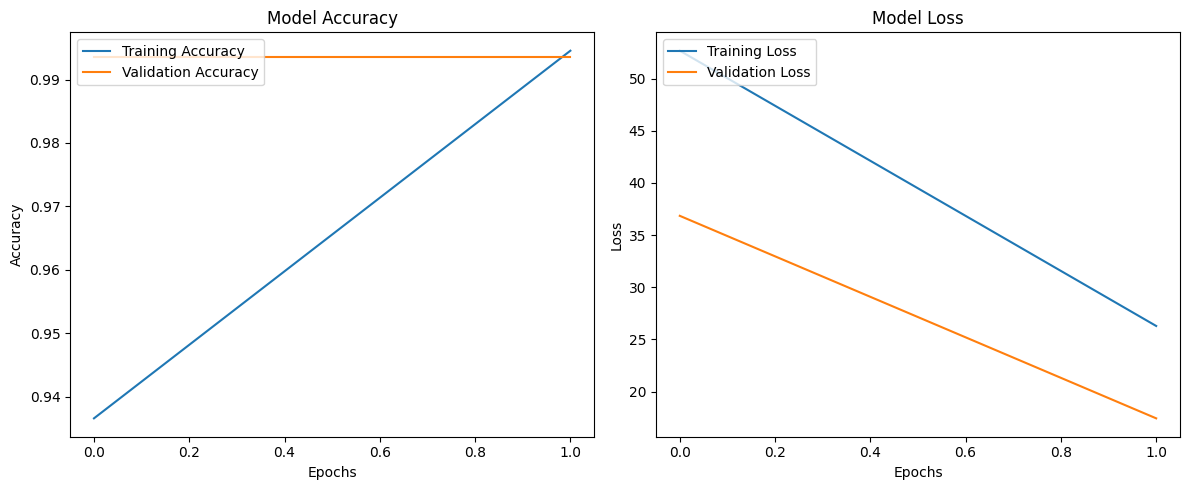

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have trained the model and stored the training history in 'history'

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Adjust layout to make the plots fit better
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 66ms/step


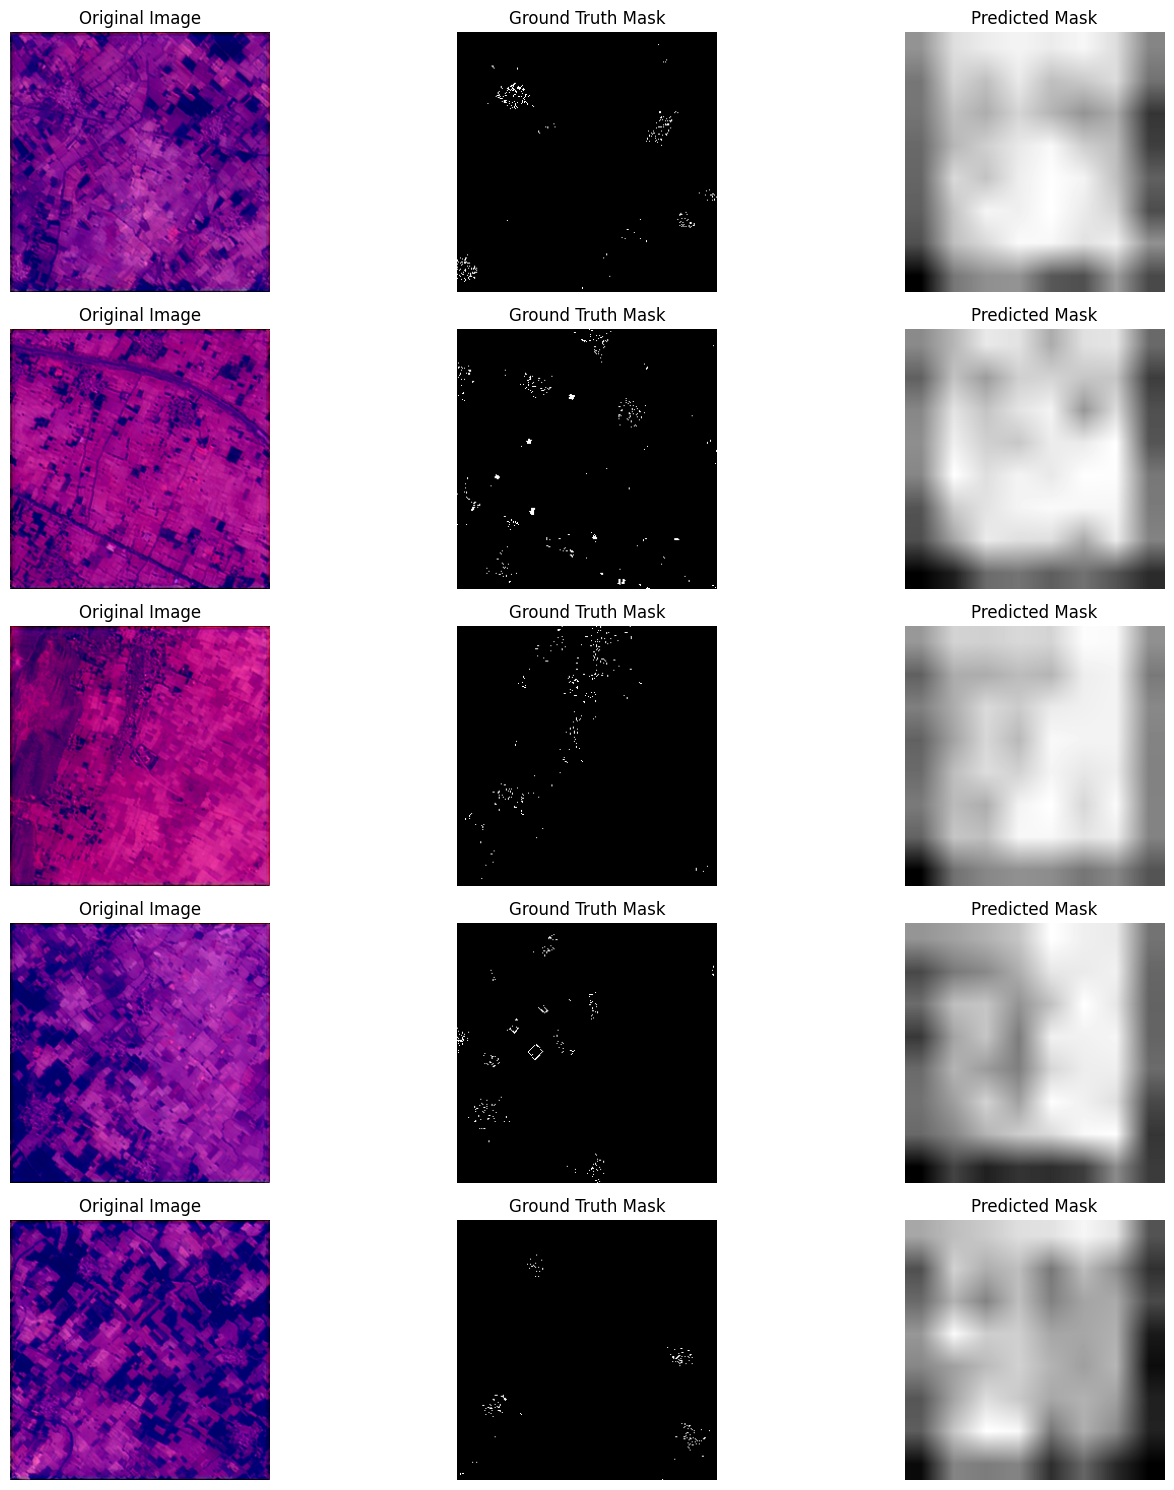

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Choose some random images from the validation set
num_images = 5  # Number of images to visualize
random_indices = np.random.choice(len(X_val), num_images)

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    # Original image
    ax = plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(X_val[idx])  # Display the original image
    ax.set_title("Original Image")
    plt.axis("off")

    # Ground truth mask
    ax = plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(y_val[idx].squeeze(), cmap='gray')  # Squeeze the mask to remove extra dimensions if any
    ax.set_title("Ground Truth Mask")
    plt.axis("off")

    # Model prediction
    pred_mask = model.predict(np.expand_dims(X_val[idx], axis=0))[0]  # Make a prediction for the image
    ax = plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(pred_mask, cmap='gray')  # Display the predicted mask
    ax.set_title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
#plotting resnet plus unet for bad pixel

In [ ]:
#bad dataset
import numpy as np
import tensorflow as tf
import os
import psutil

# Disable XLA to reduce memory usage (optional)
tf.config.optimizer.set_experimental_options({'auto_mixed_precision': False})

# Suppress unnecessary TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress warnings and info messages

# Load the pre-split datasets
X_train = np.load('/content/drive/MyDrive/full_data/data_files/split_datasets/X_train.npy')
y_train = np.load('/content/drive/MyDrive/full_data/data_files/split_datasets/y_train.npy')
X_val = np.load('/content/drive/MyDrive/full_data/data_files/split_datasets/X_val.npy')
y_val = np.load('/content/drive/MyDrive/full_data/data_files/split_datasets/y_val.npy')
X_test = np.load('/content/drive/MyDrive/full_data/data_files/split_datasets/X_test.npy')
y_test = np.load('/content/drive/MyDrive/full_data/data_files/split_datasets/y_test.npy')

print("Datasets loaded successfully from Google Drive.")

# Normalize images and masks (values between 0 and 1)
X_train = X_train.astype('float32') / 255.0
y_train = y_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
y_val = y_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_test = y_test.astype('float32') / 255.0

# Create tf.data.Dataset objects with repeat() for training dataset and optimize memory usage
def create_dataset(X, y, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Efficiently load the datasets
train_dataset = create_dataset(X_train, y_train, batch_size=32, shuffle=True)
val_dataset = create_dataset(X_val, y_val, batch_size=32, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=32, shuffle=False)

# Check the dataset sizes (print the number of batches)
print(f"Train dataset size (batches): {len(list(train_dataset))}")
print(f"Validation dataset size (batches): {len(list(val_dataset))}")
print(f"Test dataset size (batches): {len(list(test_dataset))}")

# Example of using the datasets in model training
# Assuming you have a model defined, you can train the model like this:
# history = model.fit(
#     train_dataset,
#     steps_per_epoch=len(X_train) // 32,
#     epochs=10,
#     validation_data=val_dataset,
#     validation_steps=len(X_val) // 32
# )

# Monitor memory usage to avoid crashes
def check_memory_usage():
    memory_info = psutil.virtual_memory()
    print(f"Memory Usage: {memory_info.percent}%")
    if memory_info.percent > 80:
        print("Warning: High memory usage, consider reducing batch size or freeing up memory.")

# Call memory usage monitor periodically
check_memory_usage()


Datasets loaded successfully from Google Drive.
Train dataset size (batches): 32
Validation dataset size (batches): 16
Test dataset size (batches): 16
Memory Usage: 3.6%


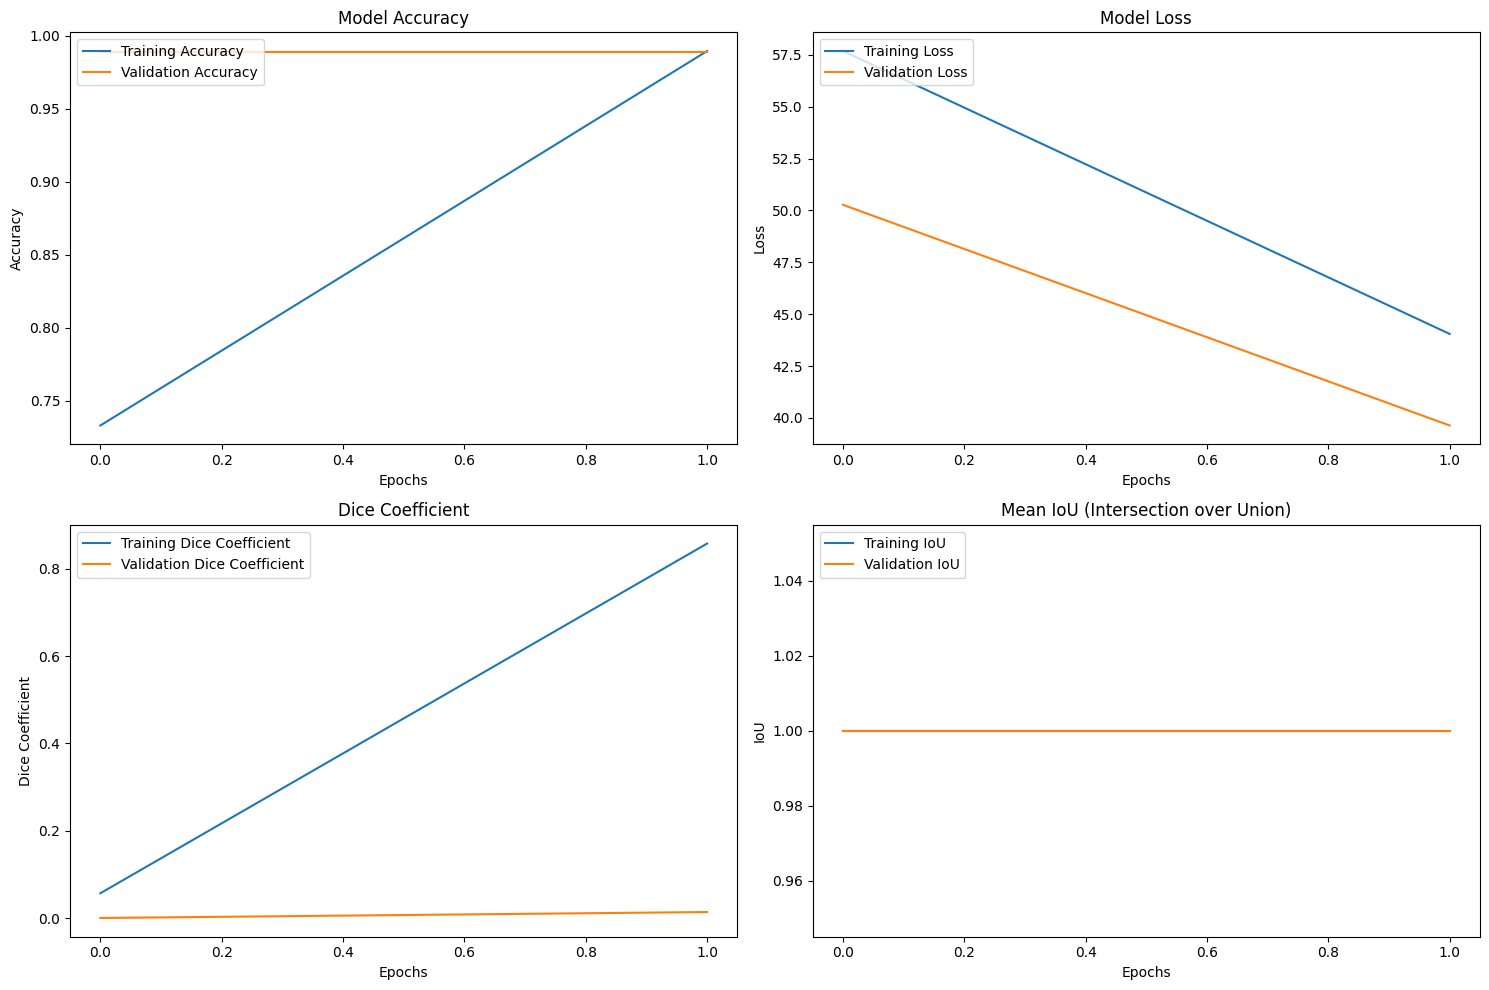

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have trained the model and stored the training history in 'history'

# Plot training & validation accuracy values
plt.figure(figsize=(15, 10))

# Plotting accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Plot Dice Coefficient
plt.subplot(2, 2, 3)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend(loc='upper left')

# Plot IoU (Intersection over Union)
plt.subplot(2, 2, 4)
plt.plot(history.history['mean_io_u'], label='Training IoU')
plt.plot(history.history['val_mean_io_u'], label='Validation IoU')
plt.title('Mean IoU (Intersection over Union)')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend(loc='upper left')

# Adjust layout to make the plots fit better
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 481ms/step


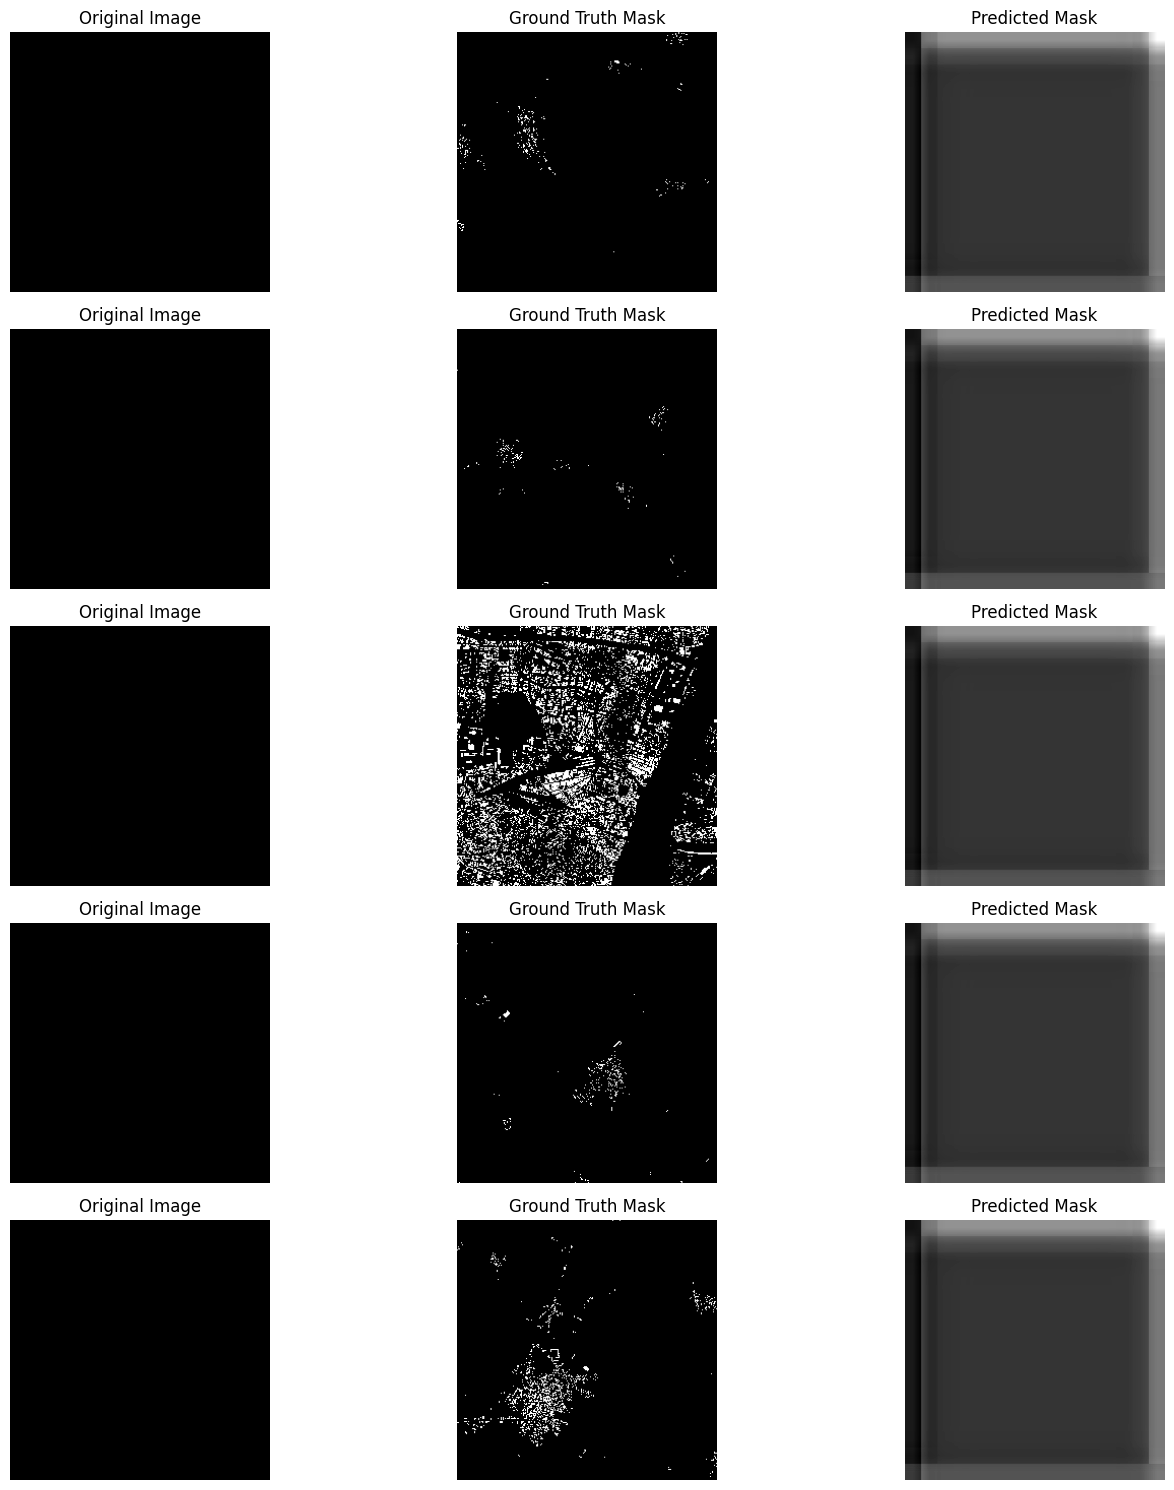

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Choose some random images from the validation set
num_images = 5  # Number of images to visualize
random_indices = np.random.choice(len(X_val), num_images)

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    # Original image
    ax = plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(X_val[idx])  # Display the original image
    ax.set_title("Original Image")
    plt.axis("off")

    # Ground truth mask
    ax = plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(y_val[idx].squeeze(), cmap='gray')  # Squeeze the mask to remove extra dimensions if any
    ax.set_title("Ground Truth Mask")
    plt.axis("off")

    # Model prediction
    # Normalize and preprocess image before feeding to the model if required
    pred_mask = model.predict(np.expand_dims(X_val[idx], axis=0) / 255.0)[0]  # Normalize image for prediction
    ax = plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(pred_mask, cmap='gray')  # Display the predicted mask
    ax.set_title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split

# Specify your folder paths
train_image_folder = '/content/drive/MyDrive/full_data/super4x3_resolution/satellite_tiff'
train_mask_folder = '/content/drive/MyDrive/full_data/super4x3_resolution/mask_tiff'
output_base_folder = '/content/drive/MyDrive/full_data/super4x3_resolution/split_dataset'

# Function to load the full dataset (both images and masks)
def load_full_dataset(image_folder, mask_folder):
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    all_images = []
    all_masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        # Load image
        img = load_img(os.path.join(image_folder, img_file), target_size=(256, 256))
        img_array = img_to_array(img)

        # Adjusted mask loading in the load_full_dataset function
        mask = load_img(os.path.join(mask_folder, mask_file), target_size=(256, 256), color_mode='grayscale')
        mask_array = img_to_array(mask)

        # Remove any extra dimensions if present
        mask_array = np.squeeze(mask_array)  # Shape will be (256, 256)
        mask_array = np.expand_dims(mask_array, axis=-1)  # Shape becomes (256, 256, 1)


        all_images.append(img_array)
        all_masks.append(mask_array)

    # Convert lists to numpy arrays
    all_images = np.array(all_images)
    all_masks = np.array(all_masks)

    return all_images, all_masks

# Load the dataset
all_images, all_masks = load_full_dataset(train_image_folder, train_mask_folder)

# Normalize images and masks (values between 0 and 1)
all_images = all_images.astype('float32') / 255.0
all_masks = all_masks.astype('float32') / 255.0

# Split the data into 80% train, 10% validation, 10% test
X_train, X_test, y_train, y_test = train_test_split(all_images, all_masks, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Check the shapes
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Create output directories for saving the splits
def create_folder_structure(base_folder):
    subsets = ['train', 'validation', 'test']
    for subset in subsets:
        os.makedirs(os.path.join(base_folder, subset, 'images'), exist_ok=True)
        os.makedirs(os.path.join(base_folder, subset, 'masks'), exist_ok=True)

create_folder_structure(output_base_folder)

# Function to save images and masks
def save_images_masks(images, masks, subset):
    image_folder = os.path.join(output_base_folder, subset, 'images')
    mask_folder = os.path.join(output_base_folder, subset, 'masks')

    for i in range(images.shape[0]):
        img = tf.keras.preprocessing.image.array_to_img(images[i])
        mask = tf.keras.preprocessing.image.array_to_img(masks[i])

        img.save(os.path.join(image_folder, f"{subset}_image_{i}.png"))
        mask.save(os.path.join(mask_folder, f"{subset}_mask_{i}.png"))

# Save the images and masks for each split
save_images_masks(X_train, y_train, 'train')
save_images_masks(X_val, y_val, 'validation')
save_images_masks(X_test, y_test, 'test')

print("Images and masks saved to Google Drive.")


Training set shape: (640, 256, 256, 3)
Validation set shape: (160, 256, 256, 3)
Test set shape: (200, 256, 256, 3)
Images and masks saved to Google Drive.


In [ ]:
# working with dataset where 10 m = 1 pixels (down)

In [ ]:
import numpy as np
import os

# Define the save path in your Google Drive
save_path = '/content/drive/MyDrive/full_data/data_files/split_datasets'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save each dataset as a .npy file
np.save(os.path.join(save_path, 'X_train.npy'), X_train)
np.save(os.path.join(save_path, 'y_train.npy'), y_train)
np.save(os.path.join(save_path, 'X_val.npy'), X_val)
np.save(os.path.join(save_path, 'y_val.npy'), y_val)
np.save(os.path.join(save_path, 'X_test.npy'), X_test)
np.save(os.path.join(save_path, 'y_test.npy'), y_test)

print("Datasets saved successfully in Google Drive.")


Datasets saved successfully in Google Drive.


In [ ]:
import numpy as np
import tensorflow as tf
import os
import psutil

# Disable XLA to reduce memory usage (optional)
tf.config.optimizer.set_experimental_options({'auto_mixed_precision': False})

# Suppress unnecessary TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress warnings and info messages

# Load the pre-split datasets
X_train = np.load('/content/drive/MyDrive/full_data/data_files/split_datasets/X_train.npy')
y_train = np.load('/content/drive/MyDrive/full_data/data_files/split_datasets/y_train.npy')
X_val = np.load('/content/drive/MyDrive/full_data/data_files/split_datasets/X_val.npy')
y_val = np.load('/content/drive/MyDrive/full_data/data_files/split_datasets/y_val.npy')
X_test = np.load('/content/drive/MyDrive/full_data/data_files/split_datasets/X_test.npy')
y_test = np.load('/content/drive/MyDrive/full_data/data_files/split_datasets/y_test.npy')

print("Datasets loaded successfully from Google Drive.")

# Normalize images and masks (values between 0 and 1)
X_train = X_train.astype('float32') / 255.0
y_train = y_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
y_val = y_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_test = y_test.astype('float32') / 255.0

# Create tf.data.Dataset objects with repeat() for training dataset and optimize memory usage
def create_dataset(X, y, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Efficiently load the datasets
train_dataset = create_dataset(X_train, y_train, batch_size=32, shuffle=True)
val_dataset = create_dataset(X_val, y_val, batch_size=32, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=32, shuffle=False)

# Check the dataset sizes (print the number of batches)
print(f"Train dataset size (batches): {len(list(train_dataset))}")
print(f"Validation dataset size (batches): {len(list(val_dataset))}")
print(f"Test dataset size (batches): {len(list(test_dataset))}")

# Example of using the datasets in model training
# Assuming you have a model defined, you can train the model like this:
# history = model.fit(
#     train_dataset,
#     steps_per_epoch=len(X_train) // 32,
#     epochs=10,
#     validation_data=val_dataset,
#     validation_steps=len(X_val) // 32
# )

# Monitor memory usage to avoid crashes
def check_memory_usage():
    memory_info = psutil.virtual_memory()
    print(f"Memory Usage: {memory_info.percent}%")
    if memory_info.percent > 80:
        print("Warning: High memory usage, consider reducing batch size or freeing up memory.")

# Call memory usage monitor periodically
check_memory_usage()


Datasets loaded successfully from Google Drive.
Train dataset size (batches): 32
Validation dataset size (batches): 16
Test dataset size (batches): 16
Memory Usage: 3.9%


In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=val_dataset,
    validation_steps=len(X_val) // 32
)


Epoch 1/10
31/31 [==============================] - 79s 2s/step - loss: 44.9437 - accuracy: 0.9600 - val_loss: 24.9192 - val_accuracy: 0.9889
Epoch 2/10
 1/31 [..............................] - ETA: 16s - loss: 24.7411 - accuracy: 0.9958

31/31 [==============================] - 8s 255ms/step - loss: 24.7411 - accuracy: 0.9958 - val_loss: 24.0231 - val_accuracy: 0.9889


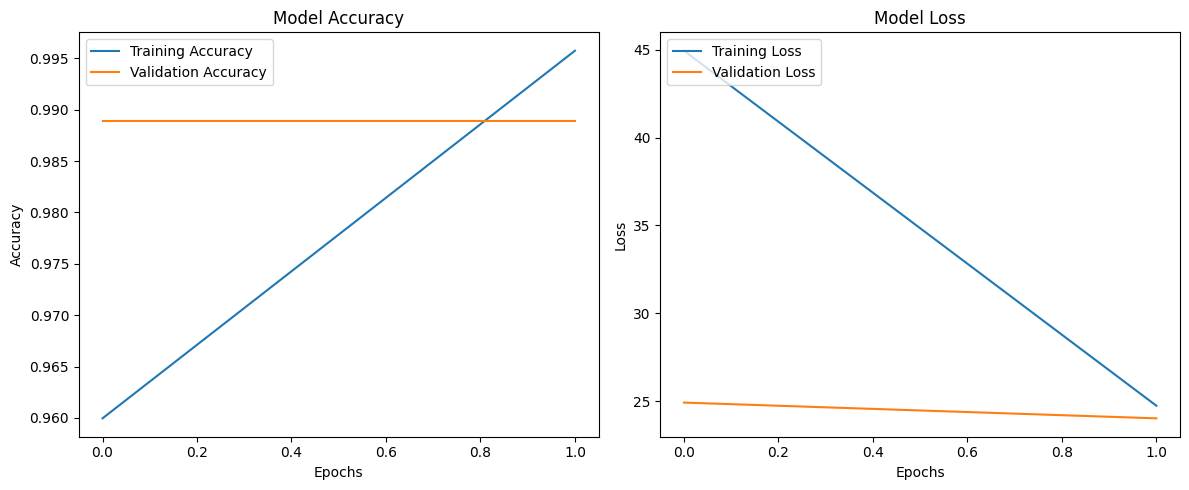

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 63ms/step


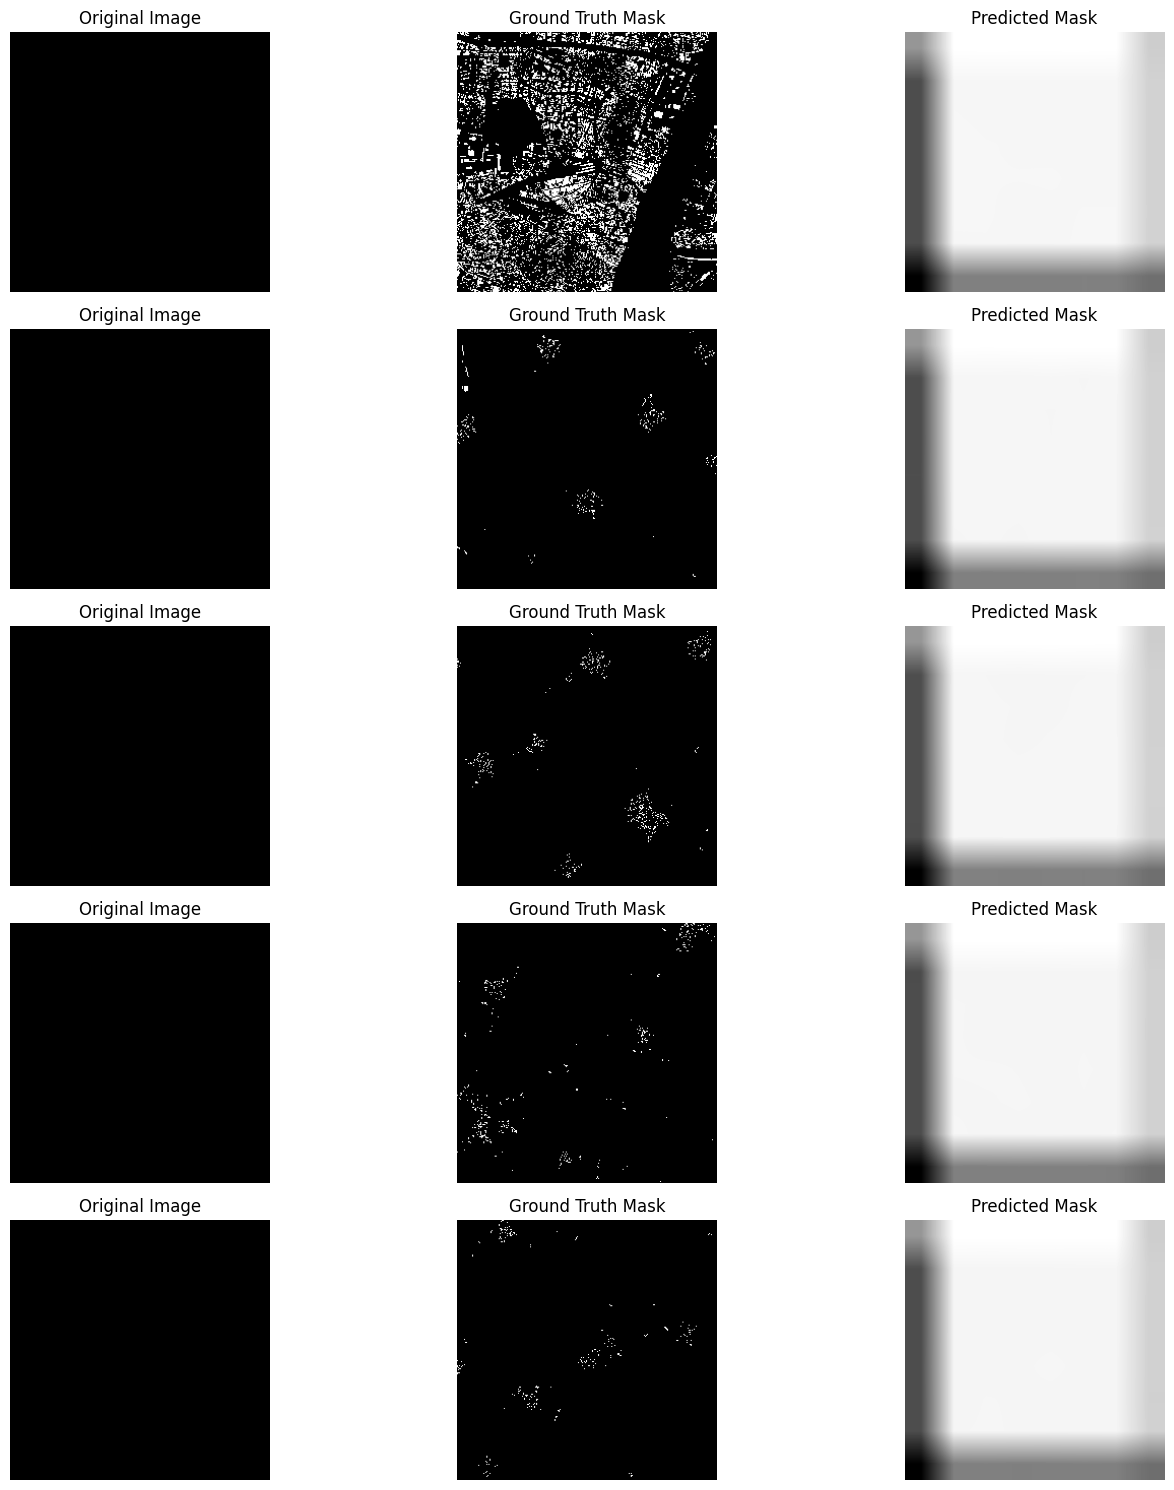

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Choose some random images from the validation set
num_images = 5  # Number of images to visualize
random_indices = np.random.choice(len(X_val), num_images)

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    # Original image
    ax = plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(X_val[idx])
    ax.set_title("Original Image")
    plt.axis("off")

    # Ground truth mask
    ax = plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(y_val[idx], cmap='gray')
    ax.set_title("Ground Truth Mask")
    plt.axis("off")

    # Model prediction
    pred_mask = model.predict(np.expand_dims(X_val[idx], axis=0))[0]
    ax = plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(pred_mask, cmap='gray')
    ax.set_title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
#trying to create dataset for arushi

In [ ]:
from PIL import Image
import numpy as np

def save_mask_image(mask_path, output_path):
    # Load the mask image
    mask_img = Image.open(mask_path)
    mask_array = np.array(mask_img)

    # Normalize the mask values to 0-255 range
    mask_array = (mask_array * 255).astype(np.uint8)  # Assumes mask is binary (0 and 1)

    # Convert array back to image
    mask_img_normalized = Image.fromarray(mask_array)

    # Save the normalized mask
    mask_img_normalized.save(output_path, format="TIFF")

# Example usage:
mask_path = '/content/drive/MyDrive/full_data/super4x3_resolution/mask_tiff/tile_11520_5248.tif.tiff'  # Path to your original mask file
output_path = '/content/drive/MyDrive/arushi dataset/mask_tile_11520_5248_normalized.tif'  # Path to save the adjusted mask

save_mask_image(mask_path, output_path)


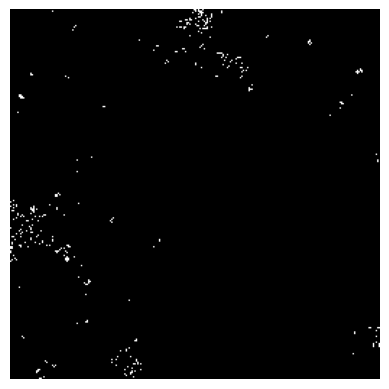

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def visualize_mask(mask_path):
    # Load the mask image
    mask_img = Image.open(mask_path)
    mask_array = np.array(mask_img)

    # Display the mask in its original form
    plt.imshow(mask_array, cmap='gray')
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
mask_path = '/content/drive/MyDrive/arushi dataset/mask_tile_11520_5248_normalized.tif'  # Path to your original mask file
visualize_mask(mask_path)


In [ ]:
import os
from PIL import Image
import numpy as np
import cv2

def create_yolo_labels(mask_folder, labels_folder, class_id=0):
    os.makedirs(labels_folder, exist_ok=True)

    for mask_file in os.listdir(mask_folder):
        if mask_file.endswith('.tif'):
            mask_path = os.path.join(mask_folder, mask_file)
            label_path = os.path.join(labels_folder, mask_file.replace('.tif', '.txt'))

            # Load mask and find contours
            mask = np.array(Image.open(mask_path))
            contours, _ = cv2.findContours((mask > 0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            with open(label_path, 'w') as label_file:
                for contour in contours:
                    x, y, w, h = cv2.boundingRect(contour)

                    # Normalize coordinates to YOLO format
                    x_center = (x + w / 2) / mask.shape[1]
                    y_center = (y + h / 2) / mask.shape[0]
                    width = w / mask.shape[1]
                    height = h / mask.shape[0]

                    label_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# Example usage
mask_folder = '/content/drive/MyDrive/arushi dataset'         # Folder containing mask TIFF files
labels_folder = '/content/drive/MyDrive/arushi dataset/labels_yolo' # Folder to save YOLO label files
create_yolo_labels(mask_folder, labels_folder)


In [ ]:
#now trying to see if without enhancing the visualization can i make it in yolo format

In [ ]:
import os
from PIL import Image
import numpy as np
import cv2

def create_yolo_label_for_single_mask(mask_file, label_file, class_id=0):
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(label_file), exist_ok=True)

    # Load mask and find contours
    mask = np.array(Image.open(mask_file))
    contours, _ = cv2.findContours((mask > 0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    with open(label_file, 'w') as label:
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            # Normalize coordinates to YOLO format
            x_center = (x + w / 2) / mask.shape[1]
            y_center = (y + h / 2) / mask.shape[0]
            width = w / mask.shape[1]
            height = h / mask.shape[0]

            label.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# Example usage
mask_file = '/content/drive/MyDrive/full_data/arushi_dataset/split_dataset/train/masks/img_0.tiff'  # Path to the mask file
label_file = '/content/drive/MyDrive/arushi_dataset/labels_yolo_no_formatting/tile_11520_5248.txt'     # Path to save the YOLO label file
create_yolo_label_for_single_mask(mask_file, label_file)


In [ ]:
import shutil

# Path to the folder you want to delete
folder_path = "/content/drive/MyDrive/arushi_dataset"

# Delete the folder and its contents
try:
    shutil.rmtree(folder_path)
    print(f"Deleted folder: {folder_path}")
except FileNotFoundError:
    print(f"The folder {folder_path} does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


Deleted folder: /content/drive/MyDrive/arushi_dataset


In [ ]:
#making full arushi dataset for yolov8

In [ ]:
pip install rasterio

In [ ]:
import os

# Define paths to the image and mask directories
image_folder = '/content/drive/MyDrive/full_data/arushi_dataset/split_dataset/train/images'
mask_folder = '/content/drive/MyDrive/full_data/arushi_dataset/split_dataset/train/masks'

# List all files, remove prefixes 'image_' and 'mask_', and keep the main file name (number) without extensions
image_files = {os.path.splitext(f)[0].replace("image_", "") for f in os.listdir(image_folder) if f.endswith(('.tif', '.tiff'))}
mask_files = {os.path.splitext(f)[0].replace("mask_", "") for f in os.listdir(mask_folder) if f.endswith(('.tif', '.tiff'))}

# Find mask files without corresponding image files
mask_without_image = mask_files - image_files
# Find image files without corresponding mask files
image_without_mask = image_files - mask_files

# Print results with mismatched files
print(f"\nNumber of mask files without corresponding image files: {len(mask_without_image)}")
print(f"Number of image files without corresponding mask files: {len(image_without_mask)}")

# Print mismatched file names for deeper inspection
if mask_without_image:
    print("\nMask files without corresponding image files:")
    for file in mask_without_image:
        print(file)

if image_without_mask:
    print("\nImage files without corresponding mask files:")
    for file in image_without_mask:
        print(file)

# Check for files that have both a corresponding image and mask
matching_files = image_files & mask_files
print(f"\nNumber of matching files: {len(matching_files)}")
if matching_files:
    print("Matching files (with both image and mask):")
    for file in matching_files:
        print(file)



Number of mask files without corresponding image files: 0
Number of image files without corresponding mask files: 0

Number of matching files: 640
Matching files (with both image and mask):
train_91
train_325
train_135
train_496
train_187
train_335
train_297
train_499
train_429
train_607
train_111
train_79
train_192
train_342
train_47
train_25
train_231
train_46
train_504
train_550
train_617
train_579
train_291
train_348
train_627
train_295
train_599
train_613
train_263
train_240
train_76
train_478
train_256
train_149
train_277
train_221
train_452
train_561
train_296
train_355
train_283
train_2
train_248
train_151
train_388
train_589
train_515
train_9
train_634
train_101
train_261
train_548
train_33
train_553
train_184
train_170
train_334
train_160
train_84
train_126
train_489
train_581
train_139
train_615
train_541
train_186
train_480
train_455
train_37
train_456
train_430
train_39
train_612
train_332
train_53
train_102
train_168
train_207
train_110
train_338
train_357
train_278
trai

In [ ]:
import os
import re

# Paths to your directories
folders = {
    "train_images": "/content/drive/MyDrive/full_data/arushi_dataset/split_dataset/train/images",
    "train_masks": "/content/drive/MyDrive/full_data/arushi_dataset/split_dataset/train/masks",
    "validation_images": "/content/drive/MyDrive/full_data/arushi_dataset/split_dataset/validation/images",
    "validation_masks": "/content/drive/MyDrive/full_data/arushi_dataset/split_dataset/validation/masks",
    "test_images": "/content/drive/MyDrive/full_data/arushi_dataset/split_dataset/test/images",
    "test_masks": "/content/drive/MyDrive/full_data/arushi_dataset/split_dataset/test/masks"
}

# Function to rename files to "img_number.tiff"
def rename_files(folder_path, prefix):
    for filename in os.listdir(folder_path):
        # Check for TIFF files only
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            # Extract number part from the filename
            number = re.search(r'\d+', filename)
            if number:
                new_filename = f"img_{number.group()}.tiff"
                os.rename(
                    os.path.join(folder_path, filename),
                    os.path.join(folder_path, new_filename)
                )
                print(f"Renamed: {filename} to {new_filename}")

# Loop through each folder and rename files
for folder_type, folder_path in folders.items():
    print(f"\nRenaming files in {folder_type} folder...")
    rename_files(folder_path, folder_type)



Renaming files in train_images folder...
Renamed: train_image_196.tiff to img_196.tiff
Renamed: train_image_350.tiff to img_350.tiff
Renamed: train_image_404.tiff to img_404.tiff
Renamed: train_image_305.tiff to img_305.tiff
Renamed: train_image_173.tiff to img_173.tiff
Renamed: train_image_227.tiff to img_227.tiff
Renamed: train_image_332.tiff to img_332.tiff
Renamed: train_image_493.tiff to img_493.tiff
Renamed: train_image_501.tiff to img_501.tiff
Renamed: train_image_59.tiff to img_59.tiff
Renamed: train_image_613.tiff to img_613.tiff
Renamed: train_image_574.tiff to img_574.tiff
Renamed: train_image_85.tiff to img_85.tiff
Renamed: train_image_601.tiff to img_601.tiff
Renamed: train_image_258.tiff to img_258.tiff
Renamed: train_image_167.tiff to img_167.tiff
Renamed: train_image_247.tiff to img_247.tiff
Renamed: train_image_24.tiff to img_24.tiff
Renamed: train_image_619.tiff to img_619.tiff
Renamed: train_image_323.tiff to img_323.tiff
Renamed: train_image_209.tiff to img_209.tif

In [ ]:
import os
import cv2
import numpy as np
import rasterio
from rasterio.plot import show
from pathlib import Path
from skimage.measure import label, regionprops
from PIL import Image

# Define paths
input_path = '/content/drive/MyDrive/full_data/arushi_dataset/split_dataset'
output_path = '/content/drive/MyDrive/full_data/arushi_dataset/yolo_format_dataset'

# Define class ID for building (assuming single class 0)
class_id = 0

# Helper function to convert mask to YOLO format
def mask_to_yolo_format(mask_path, image_shape):
    with rasterio.open(mask_path) as mask_ds:
        mask = mask_ds.read(1)  # Read the first band (binary mask)
        mask = mask > 0  # Binary mask, convert to boolean

    # Find contours of buildings
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)

    yolo_labels = []
    img_height, img_width = image_shape[:2]  # Use only height and width (ignores channels)

    # Generate YOLO format labels
    for region in regions:
        minr, minc, maxr, maxc = region.bbox
        # Calculate center and size of bounding box in normalized coordinates
        x_center = (minc + maxc) / 2 / img_width
        y_center = (minr + maxr) / 2 / img_height
        width = (maxc - minc) / img_width
        height = (maxr - minr) / img_height

        # Append the label in YOLO format
        yolo_labels.append(f"{class_id} {x_center} {y_center} {width} {height}")

    return yolo_labels

# Create the directories for the new dataset structure
def create_directories(output_path):
    os.makedirs(os.path.join(output_path, 'train', 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'train', 'labels'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'test', 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'test', 'labels'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'validation', 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_path, 'validation', 'labels'), exist_ok=True)

# Convert images and labels
def process_images_and_labels():
    create_directories(output_path)

    # Loop through the dataset
    for split in ['train', 'test', 'validation']:
        image_folder = os.path.join(input_path, split, 'images')
        mask_folder = os.path.join(input_path, split, 'masks')

        for image_file in os.listdir(image_folder):
            if image_file.endswith('.tiff') or image_file.endswith('.tif'):
                image_path = os.path.join(image_folder, image_file)

                # Create mask file name by replacing .tiff or .tif with the corresponding extension
                base_name = os.path.splitext(image_file)[0]
                mask_file = None

                # Check for both .tif and .tiff mask extensions
                for ext in ['.tif', '.tiff']:
                    potential_mask_path = os.path.join(mask_folder, base_name + ext)
                    if os.path.exists(potential_mask_path):
                        mask_file = potential_mask_path
                        break

                # If no corresponding mask file is found, skip this image
                if not mask_file:
                    print(f"Mask not found for {image_file}. Skipping...")
                    continue

                # Read image (TIFF)
                img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

                # Convert to JPEG and save
                jpg_image_path = os.path.join(output_path, split, 'images', image_file.replace('.tiff', '.jpg').replace('.tif', '.jpg'))
                cv2.imwrite(jpg_image_path, img)

                # Generate YOLO label for mask
                yolo_labels = mask_to_yolo_format(mask_file, img.shape)

                # Save label file in YOLO format
                label_file_path = os.path.join(output_path, split, 'labels', image_file.replace('.tiff', '.txt').replace('.tif', '.txt'))
                with open(label_file_path, 'w') as label_file:
                    label_file.write("\n".join(yolo_labels))

# Call function to process images and labels
process_images_and_labels()


In [ ]:
#sucessfully converted into yolo format

In [ ]:
import yaml
import os

# Define paths to your datasets
train_image_folder = '/content/drive/MyDrive/full_data/arushi_dataset/yolo_format_dataset/train/images'
train_label_folder = '/content/drive/MyDrive/full_data/arushi_dataset/yolo_format_dataset/train/labels'
val_image_folder = '/content/drive/MyDrive/full_data/arushi_dataset/yolo_format_dataset/validation/images'
val_label_folder = '/content/drive/MyDrive/full_data/arushi_dataset/yolo_format_dataset/validation/labels'

# Define class names (adjust according to your dataset)
class_names = ['building']

# Create the YAML dictionary
data_dict = {
    'train': train_image_folder,
    'val': val_image_folder,
    'nc': len(class_names),  # number of classes
    'names': class_names  # list of class names
}

# Write to a YAML file
yaml_file = '/content/drive/MyDrive/full_data/arushi_dataset/yolo_format_dataset/data.yaml'
with open(yaml_file, 'w') as file:
    yaml.dump(data_dict, file)

print(f"YAML file created at: {yaml_file}")


YAML file created at: /content/drive/MyDrive/full_data/arushi_dataset/yolo_format_dataset/data.yaml


In [ ]:
#successfully created the yaml file

In [ ]:
import shutil

# Define the path to the folder you want to delete
folder_path = '/content/drive/MyDrive/full_data/arushi_dataset/split_dataset'

# Use shutil to remove the folder and its contents
shutil.rmtree(folder_path)

print(f"Folder '{folder_path}' has been successfully deleted.")


Folder '/content/drive/MyDrive/full_data/arushi_dataset/split_dataset' has been successfully deleted.


In [ ]:
#converting my dataset back to tiff format

In [ ]:
import os
from PIL import Image

# Path to the folder containing the images
input_folder = '/content/drive/MyDrive/full_data/super4x3_resolution/split_dataset'

# Loop through each of the subfolders (train, validation, test)
for folder in ['train', 'validation', 'test']:
    folder_path = os.path.join(input_folder, folder)

    # Loop through the 'images' and 'masks' subfolders
    for subfolder in ['images', 'masks']:
        subfolder_path = os.path.join(folder_path, subfolder)

        # Loop through all PNG images in the subfolder
        for filename in os.listdir(subfolder_path):
            if filename.endswith('.png'):
                png_image_path = os.path.join(subfolder_path, filename)

                # Open the PNG image and save it as TIFF
                with Image.open(png_image_path) as img:
                    tiff_image_path = os.path.splitext(png_image_path)[0] + '.tiff'
                    img.save(tiff_image_path, format='TIFF')

                # Optionally, delete the PNG file after conversion (if desired)
                os.remove(png_image_path)


In [ ]:
#trying to convert weird pinkish image back to rgb

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to the folder containing the images
input_folder = '/content/drive/MyDrive/full_data/super4x3_resolution/split_dataset'

# Loop through each of the subfolders (train, validation, test)
for folder in ['train', 'validation', 'test']:
    folder_path = os.path.join(input_folder, folder)

    # Loop through the 'images' subfolder
    subfolder_path = os.path.join(folder_path, 'images')

    # Loop through all TIFF images in the 'images' subfolder
    for filename in os.listdir(subfolder_path):
        if filename.endswith('.tiff'):
            tiff_image_path = os.path.join(subfolder_path, filename)

            # Open the TIFF image
            with Image.open(tiff_image_path) as img:
                # Convert the image to RGB if it's not already in RGB
                img_rgb = img.convert('RGB')

                # Save the converted RGB image, replacing the original
                img_rgb.save(tiff_image_path)


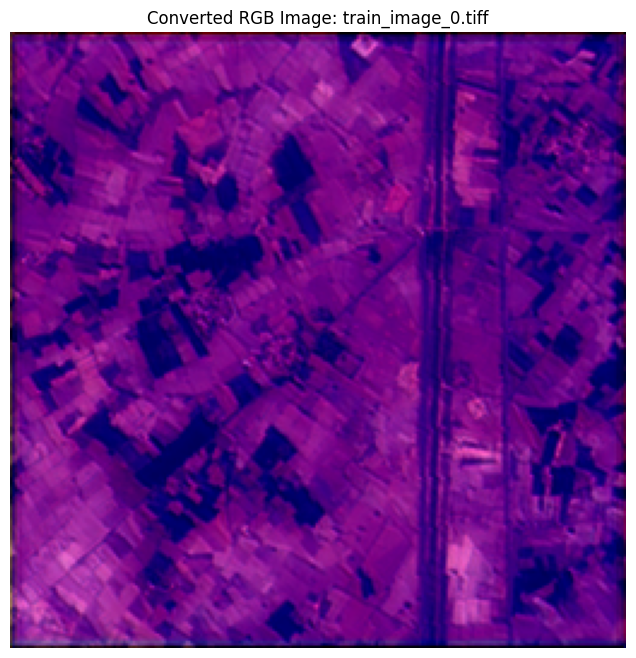

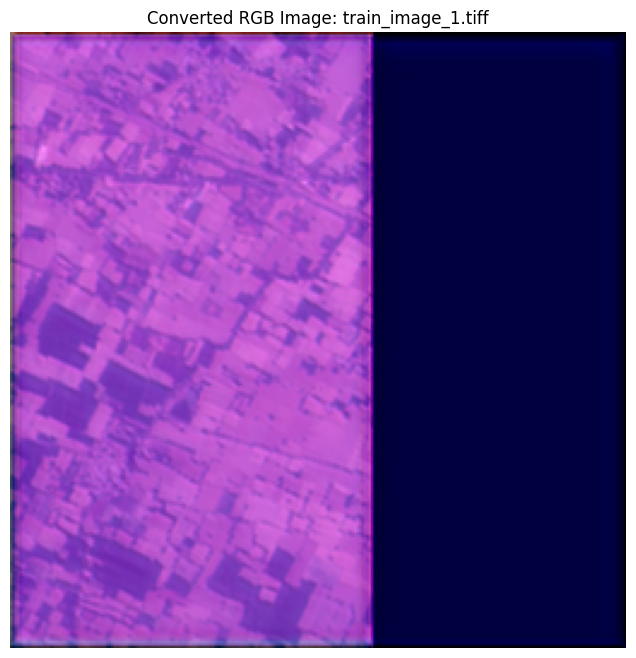

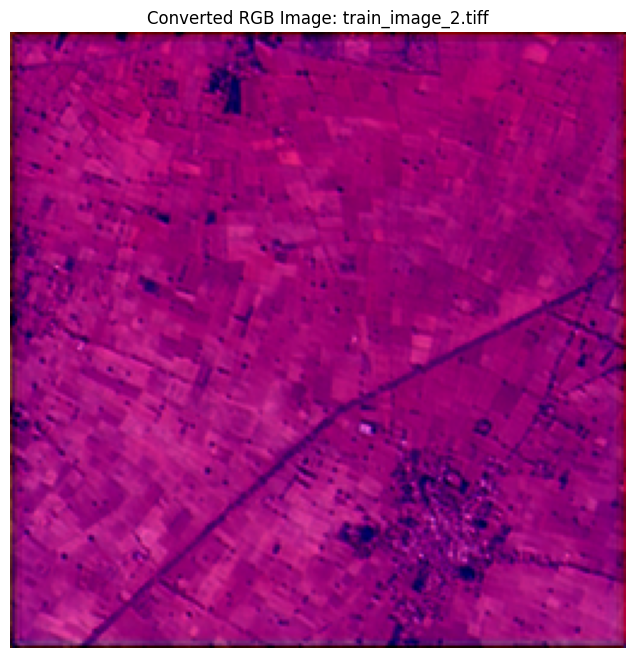

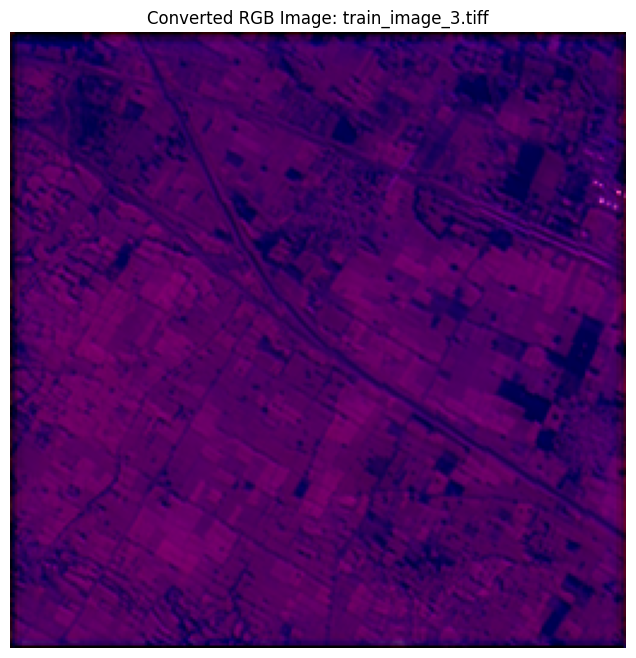

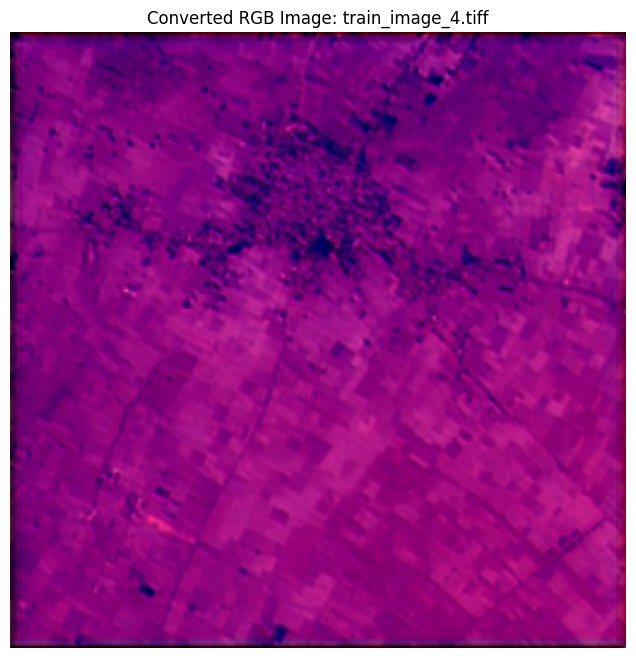

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to the folder containing the images
input_folder = '/content/drive/MyDrive/full_data/super4x3_resolution/split_dataset'

# Set the maximum number of images to visualize
max_images_to_show = 5

# Counter for visualized images
images_shown = 0

# Loop through each of the subfolders (train, validation, test)
for folder in ['train', 'validation', 'test']:
    folder_path = os.path.join(input_folder, folder)

    # Loop through the 'images' subfolder
    subfolder_path = os.path.join(folder_path, 'images')

    # Loop through all TIFF images in the 'images' subfolder
    for filename in os.listdir(subfolder_path):
        if filename.endswith('.tiff'):
            tiff_image_path = os.path.join(subfolder_path, filename)

            # Open the TIFF image
            with Image.open(tiff_image_path) as img:
                # Convert the image to RGB
                img_rgb = img.convert('RGB')

                # Save the RGB image if you want to replace the original (optional)
                # img_rgb.save(tiff_image_path)  # Uncomment if you want to replace the original image

                # Only visualize a limited number of images
                if images_shown < max_images_to_show:
                    plt.figure(figsize=(8, 8))  # Optional: Adjust figure size for better display
                    plt.imshow(img_rgb)
                    plt.axis('off')  # Hide axes
                    plt.title(f"Converted RGB Image: {filename}")  # Title with image name
                    plt.show()

                    # Increment the counter for images shown
                    images_shown += 1

                # If we've reached the max number of images to show, break out of the loop
                if images_shown >= max_images_to_show:
                    break
    if images_shown >= max_images_to_show:
        break


In [ ]:
#the images look the same as the previous one thus failed

In [ ]:
#deletion codes (useless)

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the folder path where the TIFF files are located
folder_path = '/content/drive/MyDrive/'

# Get a list of TIFF files to delete
files_to_delete = [f for f in os.listdir(folder_path) if f.endswith('.tif') or f.endswith('.tiff')]

# Loop through the files and delete them
for file in files_to_delete:
    file_path = os.path.join(folder_path, file)
    os.remove(file_path)

# Check if the files have been deleted
os.listdir(folder_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['mask_chunk_tile',
 'utm_again',
 'processed_mask_chunk_tile',
 '_12Delhi_NCR_Satellite_data.tif.aux.xml',
 'full_data']

In [ ]:
#27th november last try i would say
#big dataset
#2.5 m per pixel
#1024 * 1024

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 88.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
import rasterio
import os
from sklearn.model_selection import train_test_split

class DataPreprocessor:
    def __init__(self,
                 image_folder,
                 mask_folder,
                 target_size=(256, 256),
                 test_size=0.3,
                 val_split=0.5,
                 max_files=1000):
        """
        Initialize data preprocessor for building extraction dataset.

        Args:
            image_folder (str): Path to satellite image TIFF files
            mask_folder (str): Path to mask TIFF files
            target_size (tuple): Desired image and mask dimensions
            test_size (float): Proportion of data to reserve for testing
            val_split (float): Proportion of test data to use for validation
            max_files (int): Maximum number of files to use
        """
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.target_size = target_size
        self.test_size = test_size
        self.val_split = val_split
        self.max_files = max_files

        # Sort and limit the number of files to `max_files`
        self.image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.tif', '.tiff'))])[:max_files]
        self.mask_files = sorted([f for f in os.listdir(mask_folder) if f.lower().endswith(('.tif', '.tiff'))])[:max_files]



    def load_tiff_dataset(self):
        """
        Load TIFF images and masks, handling potential errors.

        Returns:
            tuple: Numpy arrays of images and masks
        """
        all_images = []
        all_masks = []

        for img_file, mask_file in zip(self.image_files, self.mask_files):
            try:
                # Load image (RGB channels)
                with rasterio.open(os.path.join(self.image_folder, img_file)) as src:
                    img_array = src.read([1, 2, 3])
                    img_array = np.moveaxis(img_array, 0, -1)

                # Load mask
                with rasterio.open(os.path.join(self.mask_folder, mask_file)) as src:
                    mask_array = src.read(1)

                all_images.append(img_array)
                all_masks.append(mask_array)

            except Exception as e:
                print(f"Error processing {img_file} or {mask_file}: {e}")

        return np.array(all_images), np.array(all_masks)

    def preprocess_data(self, images, masks):
      processed_images = []
      processed_masks = []

      for img, mask in zip(images, masks):
          if np.any(np.isnan(img)) or np.any(np.isnan(mask)):
              print("NaN detected in input, skipping...")
              continue

          # Resize image
          resized_img = tf.image.resize(
              img,
              self.target_size,
              method=tf.image.ResizeMethod.BILINEAR
          ).numpy()

          # Resize mask
          resized_mask = tf.image.resize(
              mask[..., np.newaxis],
              self.target_size,
              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
          ).numpy().squeeze()

          # Normalize image
          normalized_img = np.clip(resized_img.astype('float32') / 255.0, 0, 1)

          # Normalize mask (binary)
          normalized_mask = np.clip((resized_mask > 0).astype('float32'), 0, 1)

          processed_images.append(normalized_img)
          processed_masks.append(normalized_mask)
          print(f"Image shape before resizing: {img.shape}")
          print(f"Mask shape before resizing: {mask.shape}")
          print(f"Image shape after resizing: {resized_img.shape}")
          print(f"Mask shape after resizing: {resized_mask.shape}")

      print(f"Preprocessed images shape: {np.array(processed_images).shape}")
      print(f"Preprocessed masks shape: {np.array(processed_masks).shape}")

      return np.array(processed_images), np.array(processed_masks)



    def split_dataset(self, images, masks):
        """
        Split dataset into train, validation, and test sets.

        Args:
            images (np.array): Preprocessed images
            masks (np.array): Preprocessed masks

        Returns:
            dict: Dictionary containing split datasets
        """
        # First split: train vs test
        train_images, temp_images, train_masks, temp_masks = train_test_split(
            images, masks, test_size=self.test_size, random_state=42
        )

        # Second split: validation from test set
        val_images, test_images, val_masks, test_masks = train_test_split(
            temp_images, temp_masks, test_size=self.val_split, random_state=42
        )

        return {
            'train_images': train_images,
            'train_masks': train_masks,
            'val_images': val_images,
            'val_masks': val_masks,
            'test_images': test_images,
            'test_masks': test_masks
        }

    def create_tf_datasets(self, datasets, batch_size=4):
        """
        Create TensorFlow datasets with optimal configuration.

        Args:
            datasets (dict): Split datasets
            batch_size (int): Batch size for training

        Returns:
            dict: TensorFlow datasets for train, validation, and test
        """
        tf_datasets = {}

        for key in ['train', 'val', 'test']:
            images = datasets[f'{key}_images']
            masks = datasets[f'{key}_masks']

            dataset = tf.data.Dataset.from_tensor_slices((images, masks))

            if key == 'train':
                dataset = (dataset
                           .shuffle(buffer_size=len(images))
                           .batch(batch_size)
                           .prefetch(tf.data.AUTOTUNE))
            else:
                dataset = (dataset
                           .batch(batch_size)
                           .prefetch(tf.data.AUTOTUNE))

            tf_datasets[f'{key}_dataset'] = dataset

        return tf_datasets

# Usage Example
preprocessor = DataPreprocessor(
    image_folder='/content/drive/MyDrive/full_data/super4x3_resolution/satellite_tiff/',
    mask_folder='/content/drive/MyDrive/full_data/super4x3_resolution/mask_tiff/',
    max_files=1000  # Limit to 1000 files
)


# Load and preprocess data
images, masks = preprocessor.load_tiff_dataset()
preprocessed_images, preprocessed_masks = preprocessor.preprocess_data(images, masks)

# Split datasets
split_datasets = preprocessor.split_dataset(preprocessed_images, preprocessed_masks)

# Create TensorFlow datasets
tf_datasets = preprocessor.create_tf_datasets(split_datasets)

# Model training preparation
train_dataset = tf_datasets['train_dataset']
val_dataset = tf_datasets['val_dataset']
test_dataset = tf_datasets['test_dataset']

def preprocess_images_and_masks(images, masks):
    masks = tf.expand_dims(masks, axis=-1)
    print(f"Expanded mask shape: {masks.shape}")
    masks = tf.cast(masks, tf.float32)
    print(f"Preprocessed image shape: {images.shape}, Preprocessed mask shape: {masks.shape}")
    return images, masks


train_dataset = train_dataset.map(preprocess_images_and_masks)
val_dataset = val_dataset.map(preprocess_images_and_masks)


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256)
Imag

In [ ]:
for images, masks in train_dataset.take(1):
    print(images.shape, masks.shape)


(4, 256, 256, 3) (4, 256, 256, 1)


In [ ]:
print(f"Images stats: min={np.min(images)}, max={np.max(images)}, mean={np.mean(images)}")
print(f"Masks stats: min={np.min(masks)}, max={np.max(masks)}, mean={np.mean(masks)}")


Images stats: min=0.0, max=0.936274528503418, mean=0.2605145573616028
Masks stats: min=0.0, max=1.0, mean=0.00140380859375


In [ ]:
unique_mask_values = np.unique(preprocessed_masks)
print(f"Unique values in masks: {unique_mask_values}")


Unique values in masks: [0. 1.]


In [ ]:
for image, mask in tf_datasets['train_dataset'].take(1):
    print(f"Image stats: min={tf.reduce_min(image)}, max={tf.reduce_max(image)}")
    print(f"Mask stats: min={tf.reduce_min(mask)}, max={tf.reduce_max(mask)}")


Image stats: min=0.0, max=0.929411768913269
Mask stats: min=0.0, max=1.0


In [ ]:
print(f"Preprocessed Images Shape: {preprocessed_images.shape}")
print(f"Preprocessed Masks Shape: {preprocessed_masks.shape}")


Preprocessed Images Shape: (1000, 256, 256, 3)
Preprocessed Masks Shape: (1000, 256, 256)


In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.0 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, UpSampling2D, ZeroPadding2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
import tensorflow as tf


def print_shape(tensor, name):
    print(f"{name} shape: {tensor.shape}")


def identity_block(X, f, filters, stage, block, l2_reg=0.01):
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'
    F1, F2, F3 = filters  # Unpacking filters for each component

    X_shortcut = X
    print_shape(X, 'Input to identity block')

    # First component: 1x1 convolution
    X = Conv2D(F1, (1, 1), padding='same', name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After conv1')

    # Second component: 3x3 convolution
    X = Conv2D(F2, (f, f), padding='same', name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After conv2')

    # Third component: 1x1 convolution
    X = Conv2D(F3, (1, 1), padding='same', name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2c')(X)
    print_shape(X, 'After conv3')

    # Add shortcut to the output
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    print_shape(X, 'After adding shortcut')

    return X


def convolutional_block(X, f, filters, stage, block, s=2, l2_reg=0.01):
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'
    F1, F2, F3 = filters  # Unpacking filters for each component

    X_shortcut = X
    print_shape(X, 'Input to convolutional block')

    # First component: 1x1 convolution
    X = Conv2D(F1, (1, 1), strides=(s, s), padding='same', name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After conv1 in convolutional block')

    # Second component: 3x3 convolution
    X = Conv2D(F2, (f, f), padding='same', name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After conv2 in convolutional block')

    # Third component: 1x1 convolution
    X = Conv2D(F3, (1, 1), padding='same', name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(name=bn_name_base + '2c')(X)
    print_shape(X, 'After conv3 in convolutional block')

    # Apply shortcut path with stride s
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='same', name=conv_name_base + '1',
                        kernel_initializer=glorot_uniform(seed=0),
                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_name_base + '1')(X_shortcut)
    print_shape(X_shortcut, 'After shortcut conv')

    # Add the shortcut to the output
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    print_shape(X, 'After adding shortcut in convolutional block')

    return X


def decoder_block(X, skip1, skip2, skip3, skip4, padding=False):
    print_shape(X, 'Input to decoder block')

    # Padding and alignment to ensure shapes match during concatenation
    if padding:
        target_shape = X.shape[1:3]
        skip1 = tf.image.resize(skip1, target_shape)
        skip2 = tf.image.resize(skip2, target_shape)
        skip3 = tf.image.resize(skip3, target_shape)
        skip4 = tf.image.resize(skip4, target_shape)

    print_shape(skip1, 'Skip1 resized')
    print_shape(skip2, 'Skip2 resized')
    print_shape(skip3, 'Skip3 resized')
    print_shape(skip4, 'Skip4 resized')

    # Resize the skip connections using tf.image.resize
    # Resize the skip connections using tf.image.resize before upsampling
    skip1 = tf.image.resize(skip1, X.shape[1:3])
    skip2 = tf.image.resize(skip2, X.shape[1:3])
    skip3 = tf.image.resize(skip3, X.shape[1:3])
    skip4 = tf.image.resize(skip4, X.shape[1:3])

    print_shape(skip1, 'Skip1 resized')
    print_shape(skip2, 'Skip2 resized')
    print_shape(skip3, 'Skip3 resized')
    print_shape(skip4, 'Skip4 resized')

    X = UpSampling2D((2, 2))(X)
    print_shape(X, 'After first upsampling')
    # Resize skip1 to match the shape of X before concatenation
    skip1 = tf.image.resize(skip1, X.shape[1:3])
    X = concatenate([X, skip1])
    print_shape(X, 'After concatenation with skip1')

    X = UpSampling2D((2, 2))(X)
    print_shape(X, 'After second upsampling')
    # Resize skip2 to match the shape of X before concatenation
    skip2 = tf.image.resize(skip2, X.shape[1:3])
    X = concatenate([X, skip2])
    print_shape(X, 'After concatenation with skip2')

    X = UpSampling2D((2, 2))(X)
    print_shape(X, 'After third upsampling')
    # Resize skip3 to match the shape of X before concatenation
    skip3 = tf.image.resize(skip3, X.shape[1:3])
    X = concatenate([X, skip3])
    print_shape(X, 'After concatenation with skip3')

    X = UpSampling2D((2, 2))(X)
    print_shape(X, 'After fourth upsampling')
    # Resize skip4 to match the shape of X before concatenation
    skip4 = tf.image.resize(skip4, X.shape[1:3])
    X = concatenate([X, skip4])
    print_shape(X, 'After concatenation with skip4')

    return X


def ResNet50_U_Net(input_shape=(256, 256, 3), classes=1):
    X_input = Input(input_shape)
    print_shape(X_input, 'Input layer')

    X = ZeroPadding2D((1, 1))(X_input)
    print_shape(X, 'After zero padding')

    X = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    print_shape(X, 'After initial conv and activation')

    X = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(X)
    print_shape(X, 'After max pooling')
    skip1 = X

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    skip2 = X

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    skip3 = X

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    skip4 = X

    # Decoder block
    X = decoder_block(X, skip1, skip2, skip3, skip4)


    X = Conv2D(1, (1, 1), activation='sigmoid', name='final_conv')(X)
    print(f"Model output shape: {X.shape}")
    model = tf.keras.Model(inputs=X_input, outputs=X)

    print_shape(X, 'After final convolution')



    model = Model(inputs=X_input, outputs=X, name='ResNet50_U_Net')
    return model


# Example of model creation
model = ResNet50_U_Net(input_shape=(256, 256, 3))
model.summary()


Input layer shape: (None, 256, 256, 3)
After zero padding shape: (None, 258, 258, 3)
After initial conv and activation shape: (None, 129, 129, 64)
After max pooling shape: (None, 64, 64, 64)
Input to convolutional block shape: (None, 64, 64, 64)
After conv1 in convolutional block shape: (None, 64, 64, 64)
After conv2 in convolutional block shape: (None, 64, 64, 64)
After conv3 in convolutional block shape: (None, 64, 64, 256)
After shortcut conv shape: (None, 64, 64, 256)
After adding shortcut in convolutional block shape: (None, 64, 64, 256)
Input to identity block shape: (None, 64, 64, 256)
After conv1 shape: (None, 64, 64, 64)
After conv2 shape: (None, 64, 64, 64)
After conv3 shape: (None, 64, 64, 256)
After adding shortcut shape: (None, 64, 64, 256)
Input to identity block shape: (None, 64, 64, 256)
After conv1 shape: (None, 64, 64, 64)
After conv2 shape: (None, 64, 64, 64)
After conv3 shape: (None, 64, 64, 256)
After adding shortcut shape: (None, 64, 64, 256)
Input to convolutiona

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

# Cosine Learning Rate Scheduler
def cosine_lr_scheduler(epoch, total_epochs, initial_lr=1e-4):
    """
    Cosine annealing learning rate scheduler.

    Args:
        epoch (int): Current epoch number
        total_epochs (int): Total training epochs
        initial_lr (float): Initial learning rate

    Returns:
        float: Adjusted learning rate
    """
    cosine_decay = 0.5 * (1 + np.cos(np.pi * epoch / total_epochs))
    return initial_lr * cosine_decay

# Dice Coefficient Metric
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Compute Dice coefficient for binary segmentation.

    Args:
        y_true (tensor): Ground truth masks
        y_pred (tensor): Predicted masks
        smooth (float): Smoothing factor to prevent division by zero

    Returns:
        tensor: Dice coefficient
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Function to Compile and Train Model
def compile_and_train_model(model, train_dataset, val_dataset):
    """
    Compile and train the model with the specified datasets.

    Args:
        model (tf.keras.Model): The model to train.
        train_dataset (tf.data.Dataset): Training dataset.
        val_dataset (tf.data.Dataset): Validation dataset.

    Returns:
        History: Training history object.
    """
    # Hyperparameters
    batch_size = 4
    total_epochs = 50
    initial_learning_rate = 0.0001

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, clipnorm=1.0)

    # Learning Rate Scheduler
    lr_schedule = LearningRateScheduler(
        lambda epoch: cosine_lr_scheduler(epoch, total_epochs, initial_learning_rate)
    )

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        lr_schedule
    ]

    # Model Compilation
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[
            'accuracy',
            tf.keras.metrics.MeanIoU(num_classes=2),
            dice_coefficient
        ]
    )

    for batch in train_dataset.take(1):
        x_batch, y_batch = batch
        print(f"Train batch image shape: {x_batch.shape}, Train batch mask shape: {y_batch.shape}")


    # Model Training
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=total_epochs,
        callbacks=callbacks
    )

    return history

# Training preparation
# Assuming `train_dataset` and `val_dataset` are preloaded tf.data.Dataset objects
history = compile_and_train_model(model, train_dataset, val_dataset)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Train batch image shape: (4, 256, 256, 3), Train batch mask shape: (4, 256, 256, 1)
Epoch 1/50
175/175 [==============================] - 3683s 21s/step - loss: 49.8046 - accuracy: 0.9896 - mean_io_u: 0.4971 - dice_coefficient: 0.0071 - val_loss: 34.8773 - val_accuracy: 0.9943 - val_mean_io_u: 0.4971 - val_dice_coefficient: 0.0103 - lr: 1.0000e-04
Epoch 2/50
 66/175 [==========>...................] - ETA: 35:07 - loss: 30.7730 - accuracy: 0.9938 - mean_io_u: 0.4969 - dice_coefficient: 0.0111

In [ ]:
#error handling

In [ ]:
def check_data_integrity(images, masks):
    """
    Check for NaN or infinite values in the images and masks.

    Args:
        images (np.array): Array of images.
        masks (np.array): Array of masks.

    Returns:
        None
    """
    if np.any(np.isnan(images)) or np.any(np.isinf(images)):
        print("Found NaN or infinite values in images!")
    else:
        print("No NaN or infinite values in images.")

    if np.any(np.isnan(masks)) or np.any(np.isinf(masks)):
        print("Found NaN or infinite values in masks!")
    else:
        print("No NaN or infinite values in masks.")

# Call this function after loading and preprocessing your data
check_data_integrity(preprocessed_images, preprocessed_masks)

No NaN or infinite values in images.
No NaN or infinite values in masks.


In [ ]:
#trying to implement transfer learning

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
import rasterio
import os
from sklearn.model_selection import train_test_split

class DataPreprocessor:
    def __init__(self,
                 image_folder,
                 mask_folder,
                 target_size=(256, 256),
                 test_size=0.3,
                 val_split=0.5):
        """
        Initialize data preprocessor for building extraction dataset.

        Args:
            image_folder (str): Path to satellite image TIFF files
            mask_folder (str): Path to mask TIFF files
            target_size (tuple): Desired image and mask dimensions
            test_size (float): Proportion of data to reserve for testing
            val_split (float): Proportion of test data to use for validation
        """
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.target_size = target_size
        self.test_size = test_size
        self.val_split = val_split

        self.image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.tif', '.tiff'))])
        self.mask_files = sorted([f for f in os.listdir(mask_folder) if f.lower().endswith(('.tif', '.tiff'))])

    def load_tiff_dataset(self):
        """
        Load TIFF images and masks, handling potential errors.

        Returns:
            tuple: Numpy arrays of images and masks
        """
        all_images = []
        all_masks = []

        for img_file, mask_file in zip(self.image_files, self.mask_files):
            try:
                # Load image (RGB channels)
                with rasterio.open(os.path.join(self.image_folder, img_file)) as src:
                    img_array = src.read([1, 2, 3])
                    img_array = np.moveaxis(img_array, 0, -1)

                # Load mask
                with rasterio.open(os.path.join(self.mask_folder, mask_file)) as src:
                    mask_array = src.read(1)

                all_images.append(img_array)
                all_masks.append(mask_array)

            except Exception as e:
                print(f"Error processing {img_file} or {mask_file}: {e}")

        return np.array(all_images), np.array(all_masks)

    def preprocess_data(self, images, masks):
        processed_images = []
        processed_masks = []

        for img, mask in zip(images, masks):
            if np.any(np.isnan(img)) or np.any(np.isnan(mask)):
                print("NaN detected in input, skipping...")
                continue

            # Resize image
            resized_img = tf.image.resize(
                img,
                self.target_size,
                method=tf.image.ResizeMethod.BILINEAR
            ).numpy()

            # Resize mask
            resized_mask = tf.image.resize(
                mask[..., np.newaxis],
                self.target_size,
                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
            ).numpy()

            # Add channel axis to the mask
            resized_mask = np.expand_dims(resized_mask.squeeze(), axis=-1)

            # Normalize image
            normalized_img = np.clip(resized_img.astype('float32') / 255.0, 0, 1)

            # Normalize mask (binary)
            normalized_mask = np.clip((resized_mask > 0).astype('float32'), 0, 1)

            processed_images.append(normalized_img)
            processed_masks.append(normalized_mask)

            # Debugging statements
            print(f"Image shape before resizing: {img.shape}")
            print(f"Mask shape before resizing: {mask.shape}")
            print(f"Image shape after resizing: {resized_img.shape}")
            print(f"Mask shape after resizing: {resized_mask.shape}")

        print(f"Preprocessed images shape: {np.array(processed_images).shape}")
        print(f"Preprocessed masks shape: {np.array(processed_masks).shape}")

        return np.array(processed_images), np.array(processed_masks)


    def split_dataset(self, images, masks):
        """
        Split dataset into train, validation, and test sets.

        Args:
            images (np.array): Preprocessed images
            masks (np.array): Preprocessed masks

        Returns:
            dict: Dictionary containing split datasets
        """
        # First split: train vs test
        train_images, temp_images, train_masks, temp_masks = train_test_split(
            images, masks, test_size=self.test_size, random_state=42
        )

        # Second split: validation from test set
        val_images, test_images, val_masks, test_masks = train_test_split(
            temp_images, temp_masks, test_size=self.val_split, random_state=42
        )

        return {
            'train_images': train_images,
            'train_masks': train_masks,
            'val_images': val_images,
            'val_masks': val_masks,
            'test_images': test_images,
            'test_masks': test_masks
        }

    def create_tf_datasets(self, datasets, batch_size=4):
        """
        Create TensorFlow datasets with optimal configuration.

        Args:
            datasets (dict): Split datasets
            batch_size (int): Batch size for training

        Returns:
            dict: TensorFlow datasets for train, validation, and test
        """
        tf_datasets = {}

        for key in ['train', 'val', 'test']:
            images = datasets[f'{key}_images']
            masks = datasets[f'{key}_masks']

            dataset = tf.data.Dataset.from_tensor_slices((images, masks))

            if key == 'train':
                dataset = (dataset
                           .shuffle(buffer_size=len(images))
                           .batch(batch_size)
                           .prefetch(tf.data.AUTOTUNE))
            else:
                dataset = (dataset
                           .batch(batch_size)
                           .prefetch(tf.data.AUTOTUNE))

            tf_datasets[f'{key}_dataset'] = dataset

        return tf_datasets

# Usage Example
preprocessor = DataPreprocessor(
    image_folder='/content/drive/MyDrive/full_data/super4x3_resolution/satellite_tiff/',
    mask_folder='/content/drive/MyDrive/full_data/super4x3_resolution/mask_tiff/'
)

# Load and preprocess data
images, masks = preprocessor.load_tiff_dataset()
preprocessed_images, preprocessed_masks = preprocessor.preprocess_data(images, masks)

# Split datasets
split_datasets = preprocessor.split_dataset(preprocessed_images, preprocessed_masks)

# Create TensorFlow datasets
tf_datasets = preprocessor.create_tf_datasets(split_datasets)

# Model training preparation
train_dataset = tf_datasets['train_dataset']
val_dataset = tf_datasets['val_dataset']
test_dataset = tf_datasets['test_dataset']

# TensorFlow map preprocessing function
def preprocess_images_and_masks(images, masks):
    masks = tf.expand_dims(masks, axis=-1)
    print(f"Expanded mask shape: {masks.shape}")
    masks = tf.cast(masks, tf.float32)
    print(f"Preprocessed image shape: {images.shape}, Preprocessed mask shape: {masks.shape}")
    return images, masks

train_dataset = train_dataset.map(preprocess_images_and_masks)
val_dataset = val_dataset.map(preprocess_images_and_masks)


Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256, 1)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256, 1)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256, 1)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256, 1)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: (256, 256, 1)
Image shape before resizing: (1024, 1024, 3)
Mask shape before resizing: (1024, 1024)
Image shape after resizing: (256, 256, 3)
Mask shape after resizing: 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, Add,
                                     ZeroPadding2D, MaxPooling2D, AveragePooling2D, Dropout, Conv2DTranspose)
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import Model

def identity_block(X, f, filters, stage, block, l2_reg=0.01):
    # Identity block for ResNet50
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='same',
               name=conv_name_base + '2a', kernel_initializer=HeNormal(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=-1, momentum=0.9, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               name=conv_name_base + '2b', kernel_initializer=HeNormal(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=-1, momentum=0.9, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='same',
               name=conv_name_base + '2c', kernel_initializer=HeNormal(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=-1, momentum=0.9, name=bn_name_base + '2c')(X)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2, l2_reg=0.01):
    # Convolutional block for ResNet50
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a', padding='same',
               kernel_initializer=HeNormal(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=-1, momentum=0.9, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides=(1, 1), name=conv_name_base + '2b', padding='same',
               kernel_initializer=HeNormal(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=-1, momentum=0.9, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides=(1, 1), name=conv_name_base + '2c', padding='same',
               kernel_initializer=HeNormal(seed=0),
               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X)
    X = BatchNormalization(axis=-1, momentum=0.9, name=bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), name=conv_name_base + '1', padding='same',
                        kernel_initializer=HeNormal(seed=0),
                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(X_shortcut)
    X_shortcut = BatchNormalization(axis=-1, momentum=0.9, name=bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(256, 256, 3), classes=1, dropout_rate=0.5):
    # Define ResNet50 modified for binary segmentation
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(1, 1), name='conv1', kernel_initializer=HeNormal(seed=0))(X)
    X = BatchNormalization(axis=-1, momentum=0.9, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stages 2, 3, and 4
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')

    # Average Pooling
    X = AveragePooling2D(pool_size=(2, 2))(X)

    # Dropout Layer
    X = Dropout(dropout_rate)(X)

    # Final Convolutional Layer for Segmentation (sigmoid activation)
    X = Conv2D(1, (1, 1), activation='sigmoid', name='conv_final')(X)

    # Transposed Convolution for Output Scaling (resize to original input size)
    X = Conv2DTranspose(classes, (32, 32), strides=(32, 32), padding='same', activation='sigmoid')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50_Segmentation')

    return model

# Compile the model
focal_loss = tf.keras.losses.BinaryFocalCrossentropy()
model = ResNet50(input_shape=(256, 256, 3), classes=1, dropout_rate=0.5)
model.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy'])

# Print model summary
print("Model Summary:")
model.summary()

# Add print statements to debug input/output shapes of key layers
print("\nDebugging input/output shapes at key layers:")
for layer in model.layers:
    print(f"Layer: {layer.name}, Input Shape: {layer.input_shape}, Output Shape: {layer.output_shape}")



Model Summary:
Model: "ResNet50_Segmentation"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d_3 (ZeroPadd  (None, 262, 262, 3)          0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1 (Conv2D)              (None, 256, 256, 64)         9472      ['zero_padding2d_3[0][0]']    
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 256, 256, 64)         256  

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Loss Functions ---
def dice_loss(y_true, y_pred, smooth=tf.keras.backend.epsilon()):
    y_true_f = tf.reshape(y_true, [-1])  # Flatten
    y_pred_f = tf.reshape(y_pred, [-1])  # Flatten
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def weighted_bce_loss(y_true, y_pred, pos_weight=2.0):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    weights = y_true * pos_weight + (1 - y_true)  # Weight positive and negative samples
    return tf.reduce_mean(weights * bce(y_true, y_pred))

def combined_loss(y_true, y_pred, dice_weight=0.5, bce_weight=0.5, pos_weight=2.0):
    bce = weighted_bce_loss(y_true, y_pred, pos_weight=pos_weight)
    dice = dice_loss(y_true, y_pred)
    return bce_weight * bce + dice_weight * dice

def dice_coefficient(y_true, y_pred, smooth=tf.keras.backend.epsilon()):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# --- Augmentation Functions ---
def create_augmentation_pipeline():
    image_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
    )
    mask_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
    )
    return image_datagen, mask_datagen

def augment_data(train_images, train_masks, batch_size=32):
    image_datagen, mask_datagen = create_augmentation_pipeline()
    image_generator = image_datagen.flow(train_images, batch_size=batch_size, seed=42)
    mask_generator = mask_datagen.flow(train_masks, batch_size=batch_size, seed=42)
    # Check image and mask shapes after augmentation
    for img, mask in zip(image_generator, mask_generator):
        print(f"Augmented image shape: {img.shape}")
        print(f"Augmented mask shape: {mask.shape}")
        break  # Check one batch

    # Combine generators into a single generator for training
    train_generator = zip(image_generator, mask_generator)

    return train_generator

# --- Visualization Functions ---
def visualize_predictions(model, val_dataset):
    for image, mask in val_dataset.take(1):  # Assuming val_dataset is a tf.data.Dataset
        pred_mask = model.predict(image[tf.newaxis, ...])
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(image.numpy())
        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(mask.numpy(), cmap="gray")
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask[0, ..., 0], cmap="gray")
        plt.show()

# --- Optimizer and Learning Rate Scheduler ---
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# --- Model Compilation ---
model.compile(
    optimizer=optimizer,
    loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.5, bce_weight=0.5, pos_weight=2.0),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=2, name='IoU'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        dice_coefficient
    ]
)

# --- Callbacks ---
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        save_best_only=True,
        monitor='val_dice_coefficient',
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=10,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=5,
        monitor='val_loss',
        mode='min',
        min_lr=1e-6,
        verbose=1
    )
]

# Augment the data with the preprocessed images and masks
train_images = split_datasets['train_images']
train_masks = split_datasets['train_masks']

# Augment the data
train_generator = augment_data(train_images, train_masks, batch_size=32)

# --- Training ---
history = model.fit(
    train_generator,  # Use augmented `train_generator`
    validation_data=val_dataset,
    epochs=50,  # Adjust as needed
    callbacks=callbacks
)


# --- Visualization of Predictions ---
visualize_predictions(model, val_dataset)


Augmented image shape: (32, 256, 256, 3)
Augmented mask shape: (32, 256, 256, 1)
Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/lambda/binary_crossentropy/logistic_loss/mul/BroadcastGradientArgs defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-18-ade5fa246956>", line 136, in <cell line: 136>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

Incompatible shapes: [32,512,512,1] vs. [32,256,256,1]
	 [[{{node gradient_tape/lambda/binary_crossentropy/logistic_loss/mul/BroadcastGradientArgs}}]] [Op:__inference_train_function_63045]

In [ ]:
test_loss, test_accuracy, test_dice = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Dice Coefficient: {test_dice}")


In [ ]:
import matplotlib.pyplot as plt

# Plot Dice Coefficient
plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Val Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.title('Dice Coefficient over Epochs')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()
